# 0.0 Imports

In [1]:
import pandas    as pd
import numpy     as np
import seaborn   as sns
import random    as rd
import itertools as it

import pickle
import requests
import json

import matplotlib.pyplot as plt

from boruta  import BorutaPy
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings( 'ignore' )

from IPython.core.display    import HTML
from sklearn.preprocessing   import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble        import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model    import LinearRegression, Lasso, BayesianRidge

from sklearn.metrics         import max_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV



## 0.1 Import Data

In [2]:
df_raw = pd.read_csv('cars_dataset.csv')

## 0.2 Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display (HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

jupyter_settings()

def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 20)
    plt.show()
    
def with_hue(plot, feature, number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(number_of_categories):
        total = a[i] + a[i+number_of_categories]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*number_of_categories + i)]/total)
            x = patch[(j*number_of_categories + i)].get_x() + patch[(j*number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*number_of_categories + i)].get_y() + patch[(j*number_of_categories + i)].get_height() 
            plot.annotate(percentage, (x, y), size = 20)
    plt.show()
    
def ml_error(model_name, y, yhat):
    me = max_error(y, yhat)
    mae = mean_absolute_error(y, yhat)
    mse = mean_squared_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    mape = mean_absolute_percentage_error(y, yhat)
    
    return pd.DataFrame({'Model name': model_name,
                         'ME': me,
                         'MAE': mae,
                         'MSE': mse,
                         'RMSE': rmse,
                         'MAPE': mape}, index=[0])




Populating the interactive namespace from numpy and matplotlib


In [4]:
def cross_validation(df_aux, kfold, model_name, model, verbose=False):
    df_aux['id_aux'] = df_aux.index%kfold

    me_cv = []
    mae_cv = []
    mse_cv = []
    rmse_cv = []
    mape_cv = []
    
    matriz_p=[]
    
    for i in range (0, kfold):
    
        df_aux_train = df_aux[(df_aux['id_aux'] != i)]
        df_aux_test  = df_aux[(df_aux['id_aux'] == i)]
    
        X_aux_train = df_aux_train.drop(['price'], axis=1).copy()
        y_aux_train = df_aux_train[['price']].copy()
    
        X_aux_test = df_aux_test.drop(['price'], axis=1).copy()
        y_aux_test = df_aux_test[['price']].copy()
    
        model.fit(X_aux_train, y_aux_train.values.ravel())
    
        yhat_lr_aux = model.predict(X_aux_test)
    
        result_aux = ml_error(model_name, y_aux_test, yhat_lr_aux)
        matriz_p.append(result_aux)
        print(result_aux)
    
        me_cv.append(result_aux['ME'])
        mae_cv.append(result_aux['MAE'])
        mse_cv.append(result_aux['MSE'])
        rmse_cv.append(result_aux['RMSE'])
        mape_cv.append(result_aux['MAPE'])
        

    return pd.DataFrame({'Model Name': model_name,
                         'ME CV' : np.round(np.mean(me_cv), 2).astype(str) + ' +/- ' + np.round(np.std(me_cv), 2).astype(str),
                         'MAE CV' : np.round(np.mean(mae_cv), 2).astype(str) + ' +/- ' + np.round(np.std(mae_cv), 2).astype(str),
                         'MSE CV' : np.round(np.mean(mae_cv), 2).astype(str) + '+/- ' + np.round(np.std(mse_cv), 2).astype(str),
                         'RMSE CV' : np.round(np.mean(rmse_cv), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_cv), 2).astype(str),
                         'MAPE CV' : np.round(np.mean(mape_cv), 2).astype(str) + ' +/- ' + np.round(np.std(mape_cv), 2).astype(str)}, index=[0])

# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Make
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi


## 1.1 Data Dimension

In [7]:
print('Number of rows {}'.format(df1.shape[0]))
print('Number of cols {}'.format(df1.shape[1]))

Number of rows 72435
Number of cols 10


## 1.2 Data Columns

In [8]:
cols_new = ['model', 'year', 'price', 'transmission', 'mileage', 'fuel_type', 'tax', 'mpg', 'engine_size', 'make']
df1.columns = cols_new

df1 = df1[['model', 'year', 'transmission', 'mileage', 'fuel_type', 'tax', 'mpg', 'engine_size', 'make', 'price']]

In [9]:
df1.head()

,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,make,price
0,A1,2017,Manual,15735,Petrol,150.0,55.4,1.4,audi,12500
1,A6,2016,Automatic,36203,Diesel,20.0,64.2,2.0,audi,16500
2,A1,2016,Manual,29946,Petrol,30.0,55.4,1.4,audi,11000
3,A4,2017,Automatic,25952,Diesel,145.0,67.3,2.0,audi,16800
4,A3,2019,Manual,1998,Petrol,145.0,49.6,1.0,audi,17300


## 1.3 Data Types

In [10]:
df1.dtypes

model            object
year              int64
transmission     object
mileage           int64
fuel_type        object
tax             float64
mpg             float64
engine_size     float64
make             object
price             int64
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

model           0
year            0
transmission    0
mileage         0
fuel_type       0
tax             0
mpg             0
engine_size     0
make            0
price           0
dtype: int64

## 1.5 Descriptive Statistics

### 1.5.1 Numerical Attributes

In [12]:
num_att = df1[['price', 'mileage', 'tax', 'mpg']]

In [13]:
vl1 = pd.DataFrame(num_att.apply(np.mean)).T
vl2 = pd.DataFrame(num_att.apply(np.std)).T
vl3 = pd.DataFrame(num_att.apply(np.median)).T
vl4 = pd.DataFrame(num_att.apply(min)).T
vl5 = pd.DataFrame(num_att.apply(max)).T
vl6 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
vl7 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

mat = pd.concat([vl1, vl2, vl3, vl4, vl5, vl6, vl7]).T.reset_index()
mat.columns = [ 'attributes', 'mean', 'std', 'median', 'min', 'max', 'skew', 'kurtosis']

In [14]:
mat

,attributes,mean,std,median,min,max,skew,kurtosis
0,price,16580.158708,9298.964565,14495.0,495.0,145000.0,2.173558,10.140470
1,mileage,23176.517057,21331.368316,17531.0,1.0,323000.0,1.763542,5.203693
2,tax,116.953407,64.045091,145.0,0.0,580.0,-0.096783,2.869900
3,mpg,55.852480,17.114273,55.4,0.3,470.8,9.824265,213.427280


### 1.5.2 Categorical Attributes

In [15]:
#model
df1['model'].value_counts()

 Fiesta                   6556
 Golf                     4863
 Focus                    4588
 Polo                     3287
 3 Series                 2443
 Kuga                     2225
 Yaris                    2122
 1 Series                 1969
 Aygo                     1961
 A3                       1929
 Tiguan                   1765
 Fabia                    1571
 Octavia                  1477
 Q3                       1417
 A4                       1381
 A1                       1347
 Tucson                   1300
 2 Series                 1229
 EcoSport                 1143
 I10                      1092
 5 Series                 1056
 4 Series                  995
 Passat                    915
 Up                        884
 A5                        882
 Q5                        877
 Q2                        822
 X1                        804
 Superb                    791
 A6                        748
 T-Roc                     733
 Auris                     712
 X3     

In [16]:
#year
df1['year'].value_counts()

2019    19031
2017    16227
2016    11377
2018    10111
2015     5584
2020     3316
2014     3053
2013     1989
2012      480
2011      322
2010      234
2009      223
2008      157
2007      114
2006       67
2005       52
2004       32
2003       22
2002       17
2001        8
2000        6
1999        5
1998        4
1997        2
1996        2
Name: year, dtype: int64

In [17]:
#transmission
df1['transmission'].value_counts()

Manual       43021
Semi-Auto    15364
Automatic    14046
Other            4
Name: transmission, dtype: int64

In [18]:
#fuel_type
df1['fuel_type'].value_counts()

Petrol      40370
Diesel      28918
Hybrid       2903
Other         239
Electric        5
Name: fuel_type, dtype: int64

In [19]:
#engine_size
df1['engine_size'].value_counts()

2.0    22878
1.0    16522
1.5     9120
1.6     5698
1.2     5017
3.0     4092
1.4     4012
1.8     1531
1.7      753
1.3      616
1.1      566
2.5      455
2.2      322
0.0      228
4.0      160
2.3       80
4.4       79
2.4       72
2.9       51
5.0       46
2.8       38
4.2       26
5.2       23
1.9       20
3.2       13
0.6        7
2.7        3
4.1        2
6.6        2
4.5        1
3.5        1
6.3        1
Name: engine_size, dtype: int64

In [20]:
#make
df1['make'].value_counts()

Ford       17964
vw         15157
BMW        10781
audi       10668
toyota      6738
skoda       6267
Hyundai     4860
Name: make, dtype: int64

# 2.0 Feature Engineering

In [21]:
df2 = df1.copy()

In [22]:
df2['year'] = (2020 - df2['year'])

In [23]:
df2.head()

,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,make,price
0,A1,3,Manual,15735,Petrol,150.0,55.4,1.4,audi,12500
1,A6,4,Automatic,36203,Diesel,20.0,64.2,2.0,audi,16500
2,A1,4,Manual,29946,Petrol,30.0,55.4,1.4,audi,11000
3,A4,3,Automatic,25952,Diesel,145.0,67.3,2.0,audi,16800
4,A3,1,Manual,1998,Petrol,145.0,49.6,1.0,audi,17300


## 2.1 Creating Hypotheses

**H01** - The most expensive cars are from the Audi brand

**H02** - The cheapest cars are from the Ford brand

**H03** - Newer cars are more expensive

**H04** - Automatic cars are more expensive

**H05** - Cars with less mileage are more expensive

**H06** - Electric cars are more expensive

**H07** - Cars with higher tax are more expensive

**H08** - Petrol and Diesel cars with higher mpg are more expensive

**H09** - Cars with bigger engines are more expensive

**H10** - Diesel cars have higher tax

# 3.0 Data Filtering

In [24]:
df3 = df2.copy()

## 3.1 Mileage

<AxesSubplot:xlabel='mileage'>

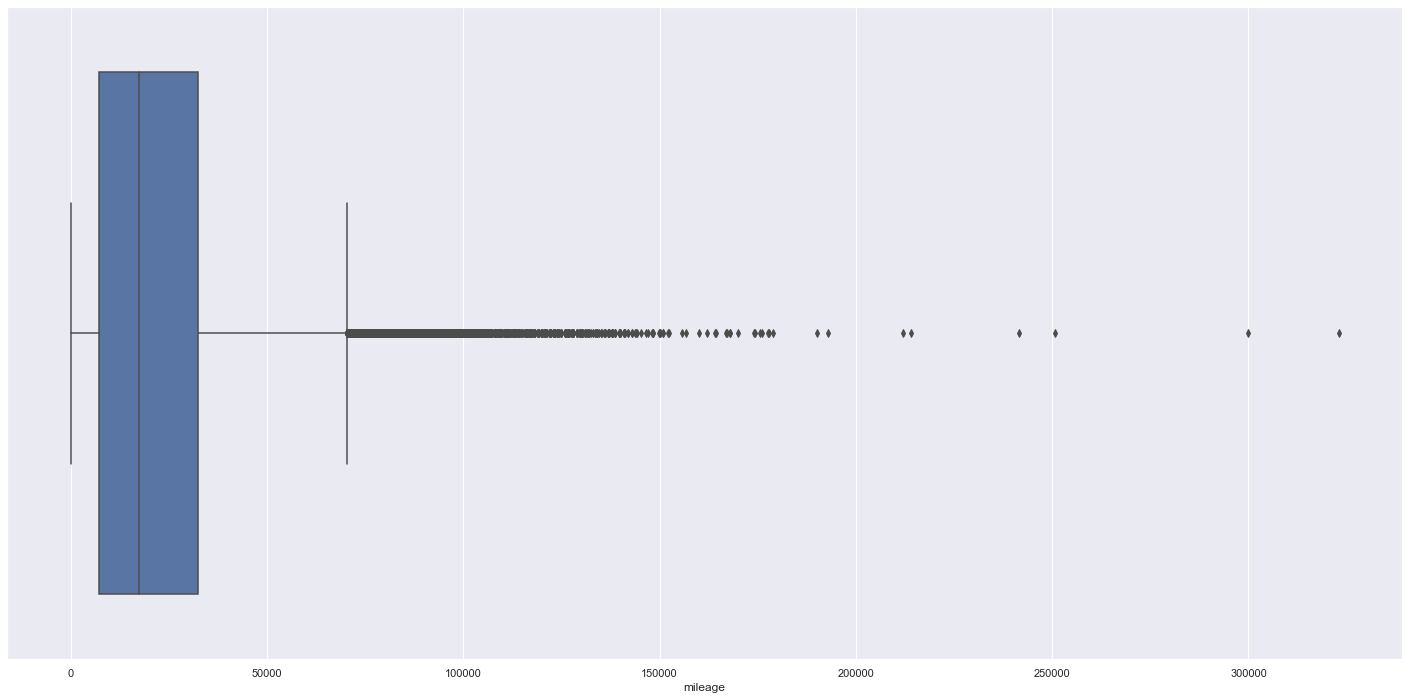

In [25]:
sns.boxplot(df3['mileage'])

In [26]:
df3[df3['mileage'] > 200000]

,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,make,price
9822,A6,12,Manual,323000,Diesel,200.0,44.1,2.0,audi,2490
20087,X5,8,Automatic,214000,Diesel,300.0,37.7,3.0,BMW,7250
52902,Caravelle,8,Semi-Auto,212000,Diesel,325.0,34.4,2.0,vw,11995
66893,Octavia,10,Manual,250650,Diesel,125.0,57.6,1.9,skoda,1485
67377,Octavia,10,Manual,300000,Diesel,125.0,57.6,1.9,skoda,1190
67400,Octavia,11,Automatic,241565,Diesel,185.0,47.9,1.9,skoda,2750


## 3.2 Mpg

<AxesSubplot:xlabel='mpg'>

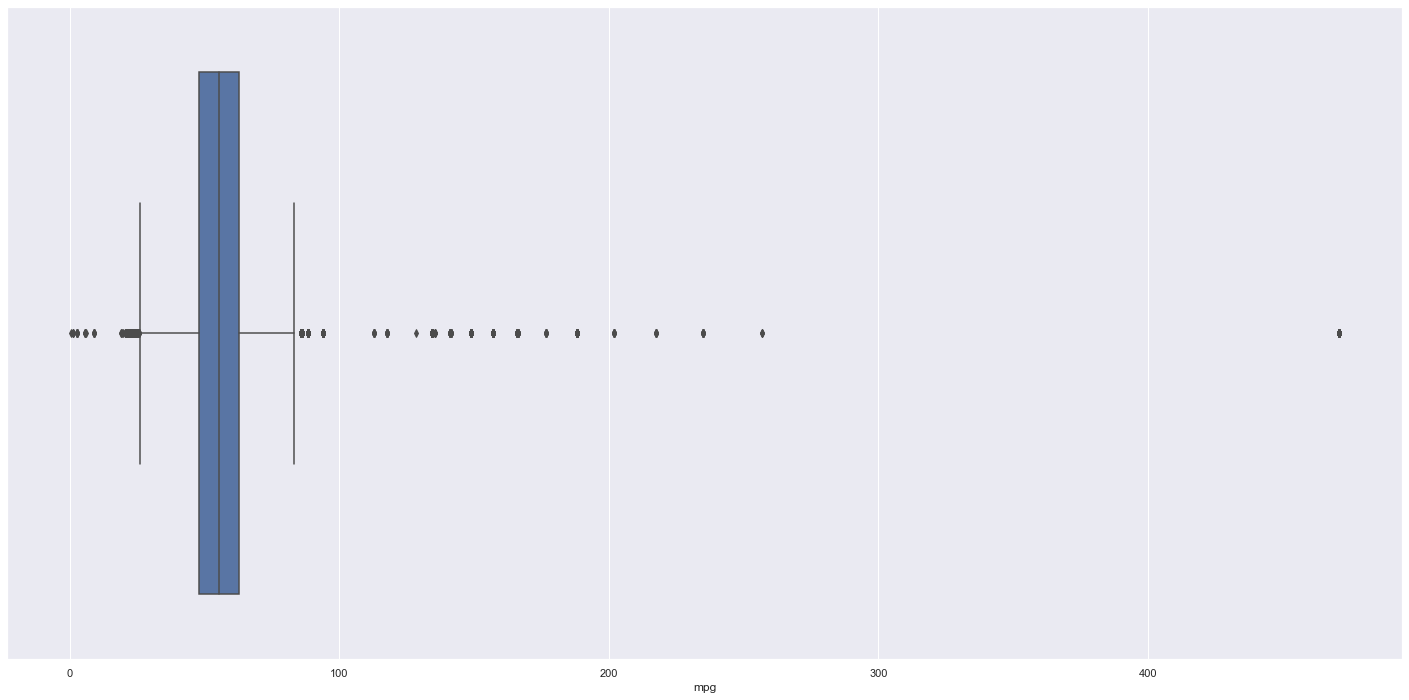

In [27]:
sns.boxplot(df3['mpg'])

In [28]:
df3[df3['mpg']>400]

,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,make,price
10700,i3,4,Automatic,25269,Other,0.0,470.8,0.6,BMW,17100
11289,i3,3,Automatic,41949,Hybrid,140.0,470.8,0.0,BMW,19998
11446,i3,3,Automatic,41146,Hybrid,0.0,470.8,0.0,BMW,19998
11448,i3,3,Automatic,10839,Hybrid,0.0,470.8,0.0,BMW,21898
12534,i3,3,Automatic,26965,Hybrid,140.0,470.8,0.0,BMW,19980
13020,i3,4,Automatic,8421,Hybrid,0.0,470.8,0.0,BMW,19490
13945,i3,4,Automatic,43695,Hybrid,0.0,470.8,0.0,BMW,16482
14296,i3,5,Automatic,65800,Hybrid,0.0,470.8,0.0,BMW,14285
14581,i3,3,Automatic,36429,Hybrid,0.0,470.8,0.0,BMW,18500
14768,i3,3,Automatic,17338,Hybrid,135.0,470.8,0.0,BMW,19495


## 3.3 Tax

<AxesSubplot:xlabel='tax'>

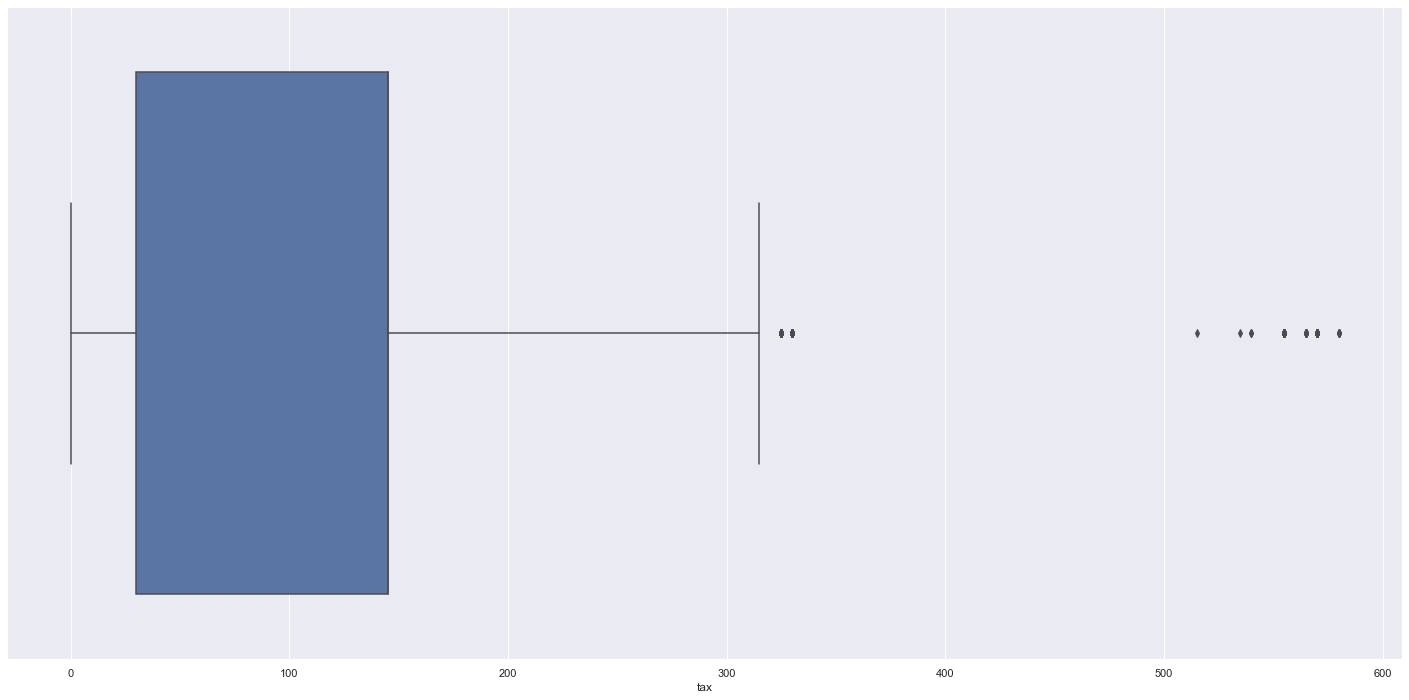

In [29]:
sns.boxplot(df3['tax'])

In [30]:
df3[df3['tax']>500]

,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,make,price
372,RS4,7,Semi-Auto,28359,Petrol,565.0,26.4,4.2,audi,26995
1869,R8,7,Manual,19834,Petrol,570.0,19.6,4.2,audi,47995
2091,RS5,6,Semi-Auto,39210,Petrol,555.0,26.9,4.2,audi,23400
3822,RS4,6,Automatic,61892,Petrol,555.0,26.4,4.2,audi,23491
4125,RS6,6,Automatic,59894,Petrol,555.0,28.8,4.0,audi,37000
4442,RS4,6,Semi-Auto,58460,Petrol,555.0,26.4,4.2,audi,26490
4758,RS4,6,Semi-Auto,70823,Petrol,555.0,26.4,4.2,audi,24990
4967,RS6,6,Automatic,63476,Petrol,555.0,28.8,4.0,audi,40990
4976,R8,6,Semi-Auto,19800,Petrol,570.0,22.8,4.2,audi,51990
5054,R8,7,Semi-Auto,10800,Petrol,570.0,22.4,4.2,audi,54850


## 3.4 Price

<AxesSubplot:xlabel='price'>

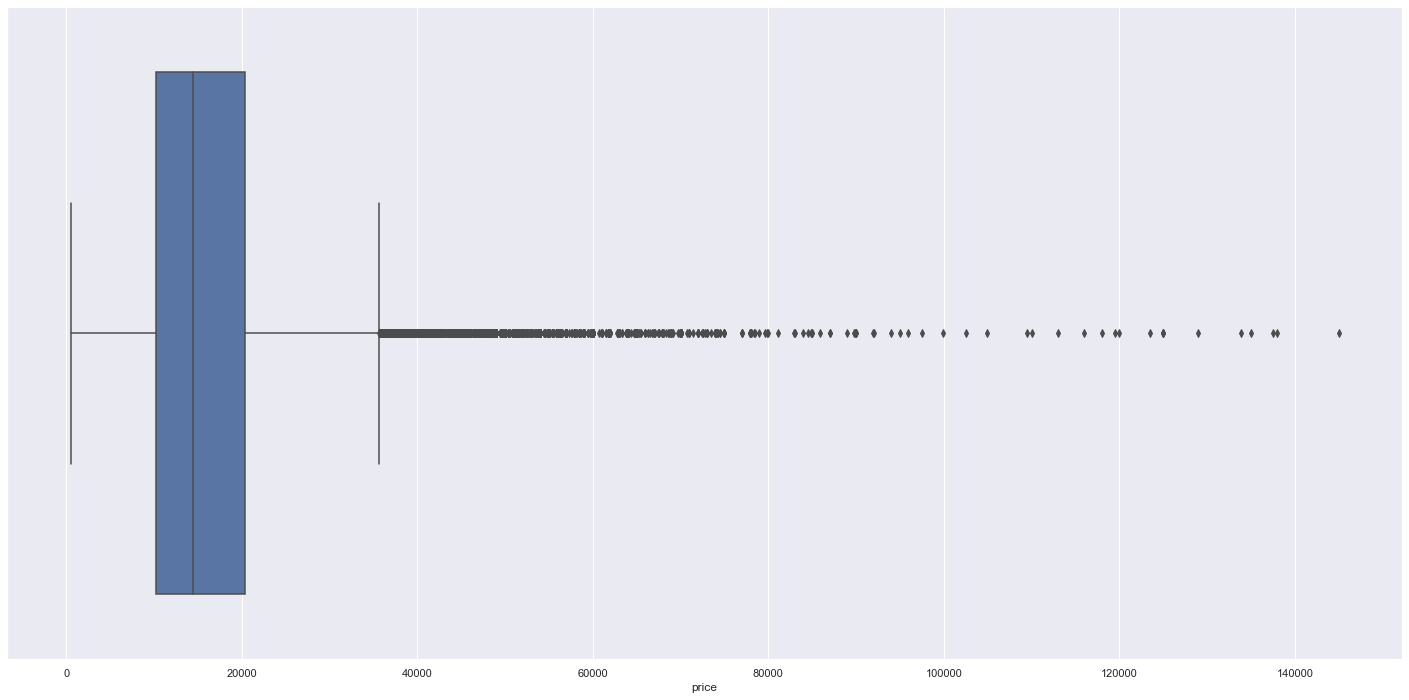

In [31]:
sns.boxplot(df3['price'])

# 4.0 Exploratory Data Analysis

In [32]:
df4=df3.copy()

## 4.1 Univariate Analysis

<AxesSubplot:xlabel='price', ylabel='Count'>

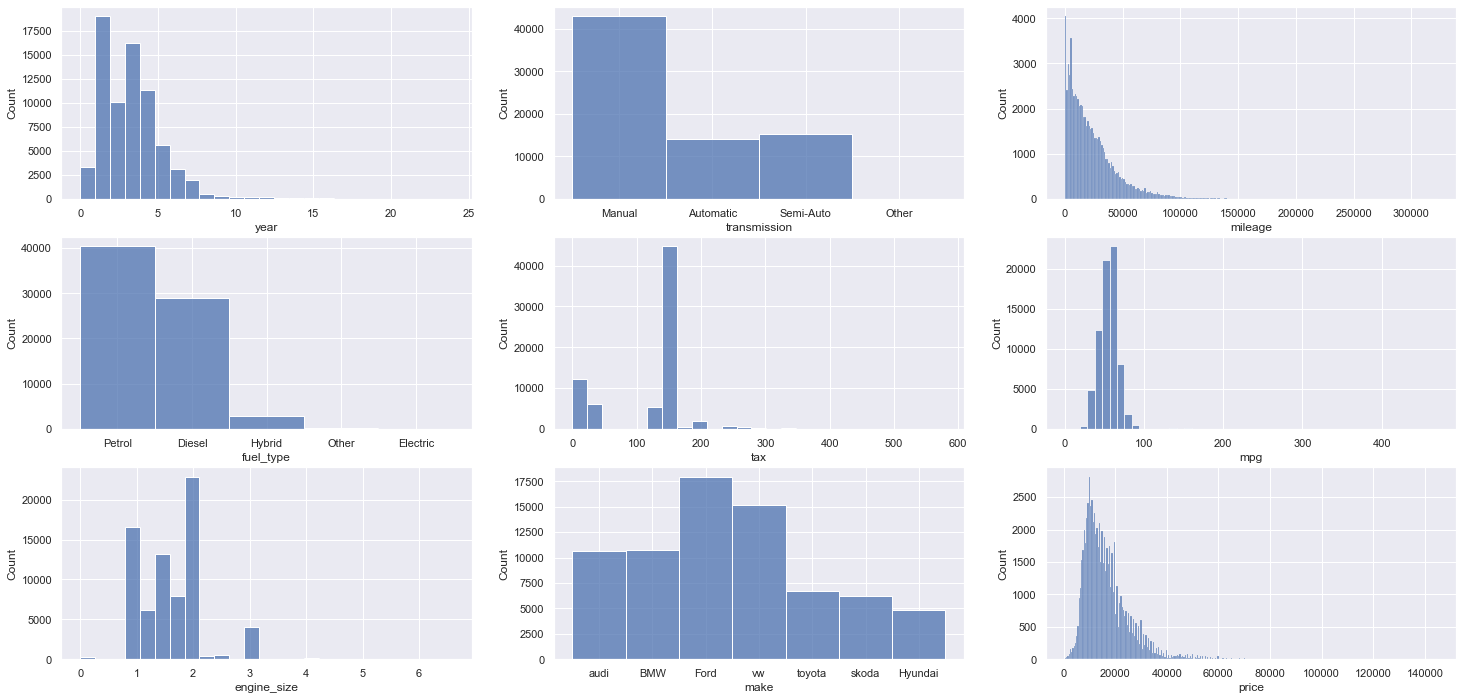

In [33]:
plt.subplot(3, 3, 1)
sns.histplot(df4['year'], bins = 25)

plt.subplot(3, 3, 2)
sns.histplot(df4['transmission'])

plt.subplot(3, 3, 3)
sns.histplot(df4['mileage'])

plt.subplot(3, 3, 4)
sns.histplot(df4['fuel_type'])

plt.subplot(3, 3 ,5)
sns.histplot(df4['tax'], bins = 25)

plt.subplot(3, 3, 6)
sns.histplot(df4['mpg'], bins = 50)

plt.subplot(3, 3, 7)
sns.histplot(df4['engine_size'], bins = 25)

plt.subplot(3, 3, 8)
sns.histplot(df4['make'])

plt.subplot(3, 3, 9)
sns.histplot(df4['price'])

## 4.2 Bivariate Analysis

### **H01** - The most expensive cars are from the Audi brand

*True* - The percentage of Audi in the 100 more expensive cars is higher than all other brands together

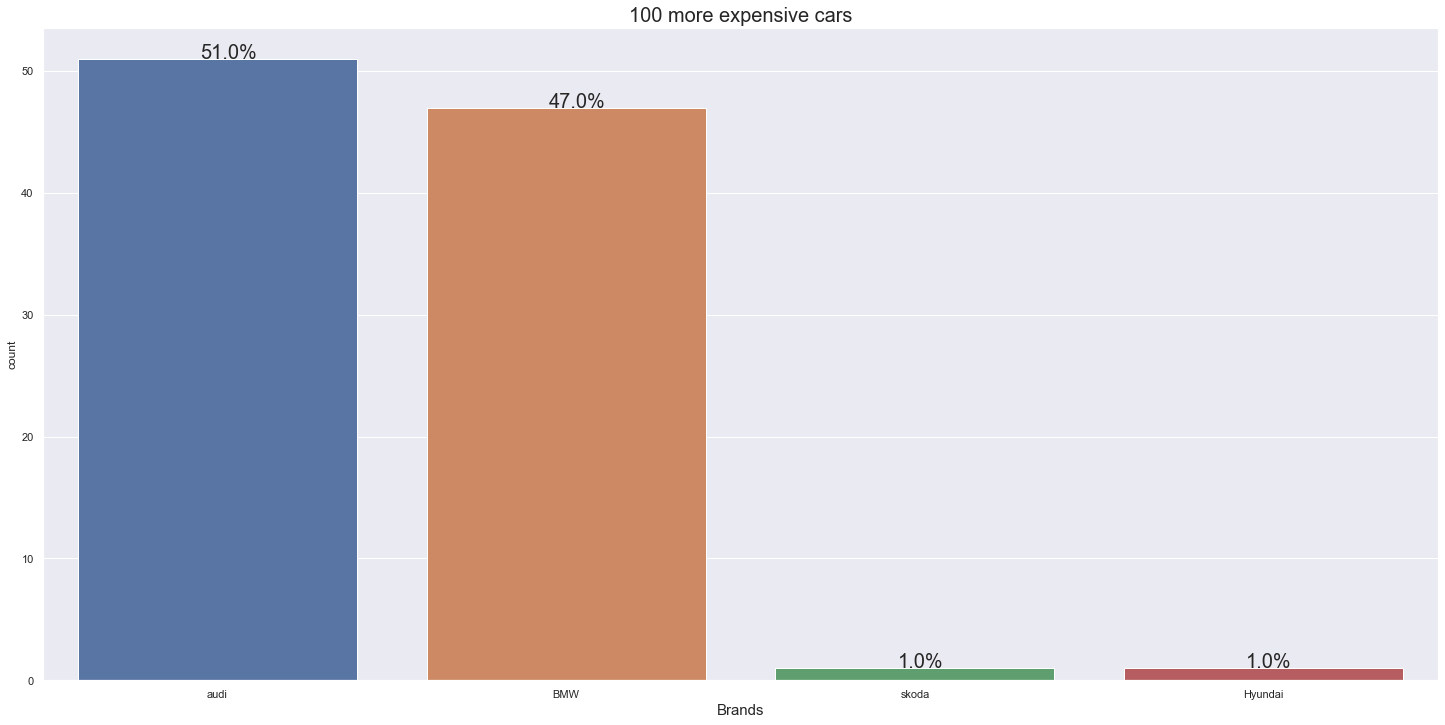

In [34]:
df_aux = df4.sort_values('price')
df_most_expensive = df_aux.tail(100)

graphic = sns.countplot(x = 'make', data = df_most_expensive)
plt.title('100 more expensive cars', fontdict = {'fontsize':20})
plt.xlabel('Brands', fontsize=15)
without_hue(graphic, df_most_expensive['make'])


### **H02** - The cheapest cars are from the Ford brand

*True* - The percentage of Ford in the 1000 cheapest cars are 39.1%

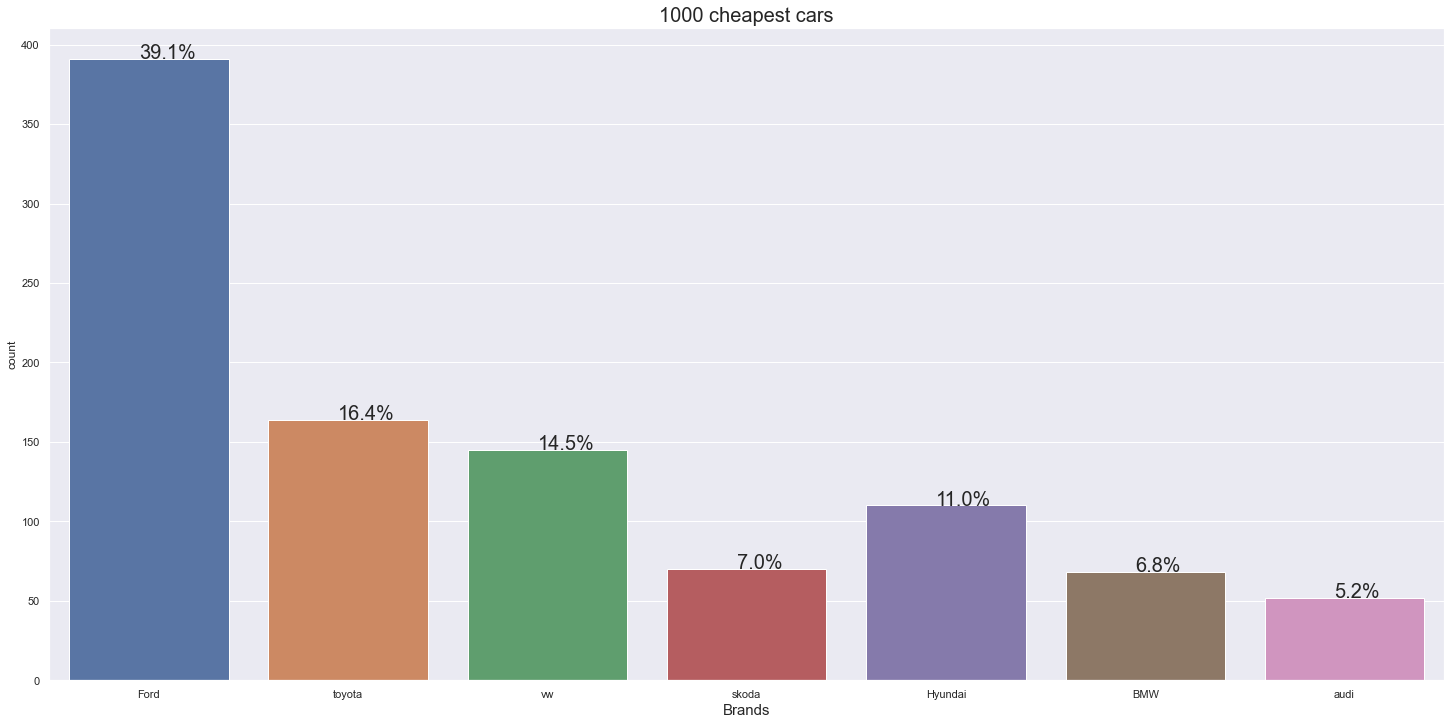

In [35]:
df_aux = df4.sort_values('price')
df_aux = df_aux.head(1000)

graphic = sns.countplot(x = 'make', data = df_aux)
plt.title('1000 cheapest cars', fontdict = {'fontsize':20})
plt.xlabel('Brands', fontsize=15)
without_hue(graphic, df_aux['make'])


### **H03** - Newer cars are more expensive

*True* - We can see in the graph that the average price of cars decreaases over the years

<AxesSubplot:title={'center':'Average price'}, xlabel='year', ylabel='price'>

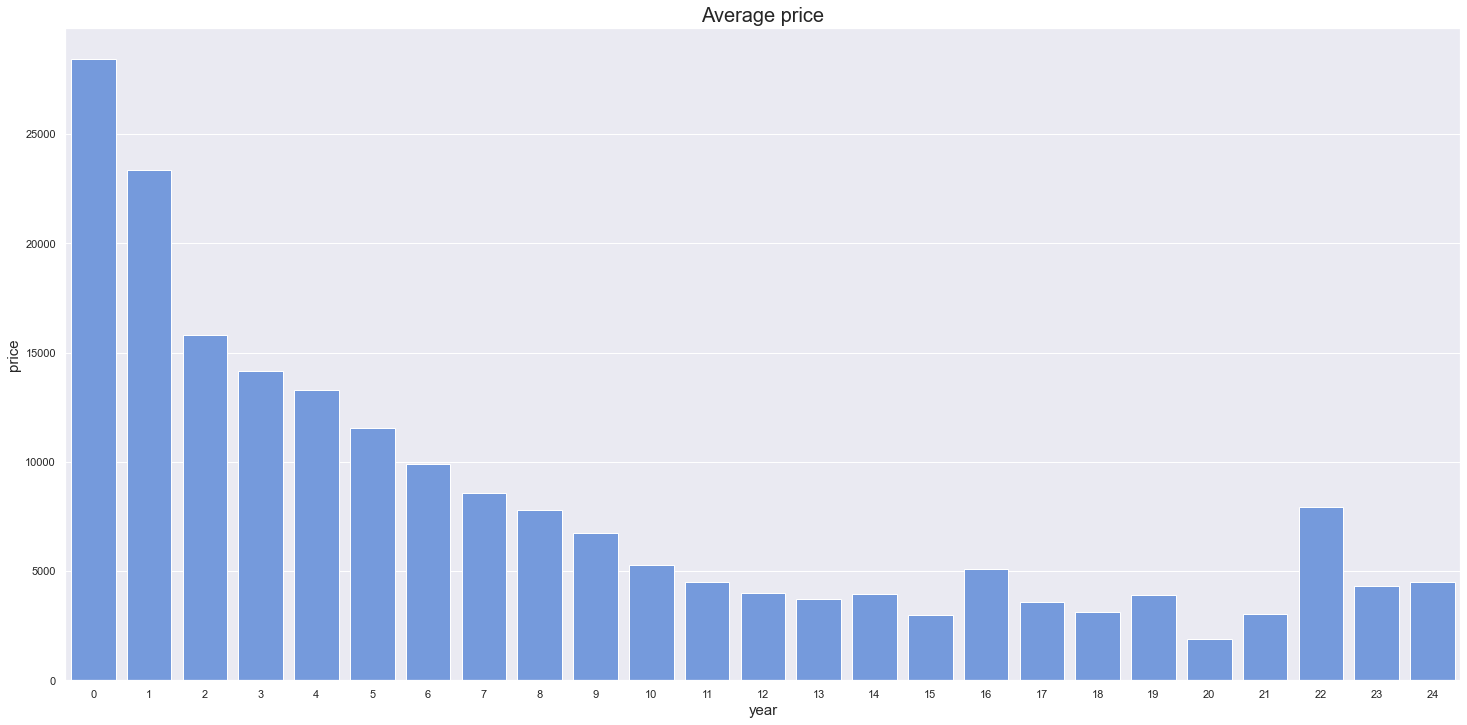

In [36]:
df_aux = df4[['year', 'price']].groupby(['year']).mean().reset_index()

plt.title('Average price', fontdict = {'fontsize':20})
plt.xlabel('year', fontsize=15)
plt.ylabel('price', fontsize=15)
sns.barplot(x='year', y='price', data=df_aux, color='cornflowerblue')

### **H04** - Automatic cars are more expensive

*False* - Semi-Auto cars are, on average, more expensive

<AxesSubplot:title={'center':'Average price'}, xlabel='transmission', ylabel='price'>

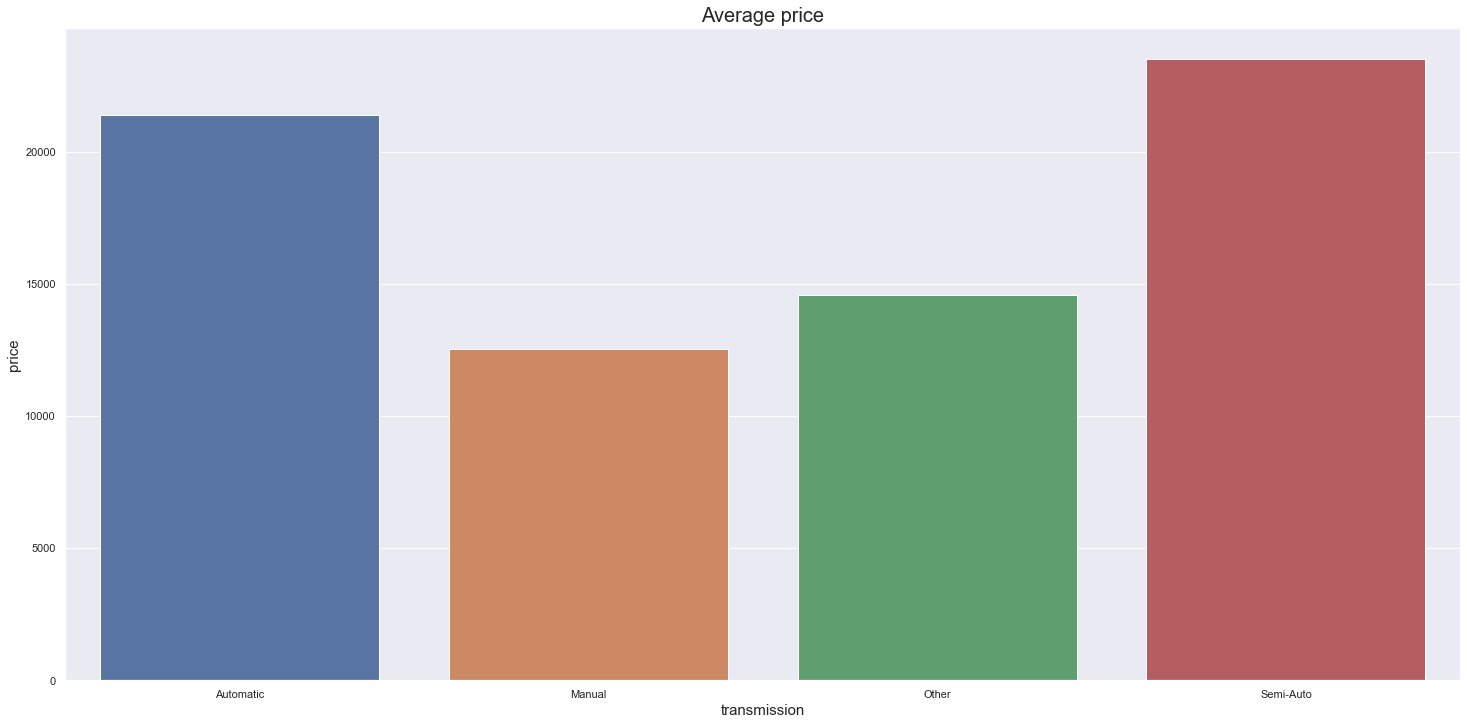

In [37]:
df_aux = df4[['transmission', 'price']].groupby(['transmission']).mean().reset_index()

plt.title('Average price', fontdict = {'fontsize':20})
plt.xlabel('transmission', fontsize=15)
plt.ylabel('price', fontsize=15)
sns.barplot(x='transmission', y='price', data=df_aux)

### **H05** - Cars with less mileage are more expensive

*True* - The most expensive cars have, on average, less mileage

In [38]:
list1 = []
for i in range(1, 11):
    aux = df4['mileage'].quantile(i*0.1)
    list1.append(aux)

df_aux = df4.copy()
df_aux['mileage'] = df_aux['mileage'].apply(lambda x: 'group01' if x < list1[0] 
                                        else 'group02'      if (x>list1[0])&(x<list1[1])
                                        else 'group03'    if (x>list1[1])&(x<list1[2])
                                        else 'group04'     if (x>list1[2])&(x<list1[3])
                                        else 'group05'     if (x>list1[3])&(x<list1[4])
                                        else 'group06'      if (x>list1[4])&(x<list1[5])
                                        else 'group07'    if (x>list1[5])&(x<list1[6])
                                        else 'group08'    if (x>list1[6])&(x<list1[7])
                                        else 'group09'     if (x>list1[7])&(x<list1[8])
                                        else 'group10')

<AxesSubplot:xlabel='mileage', ylabel='price'>

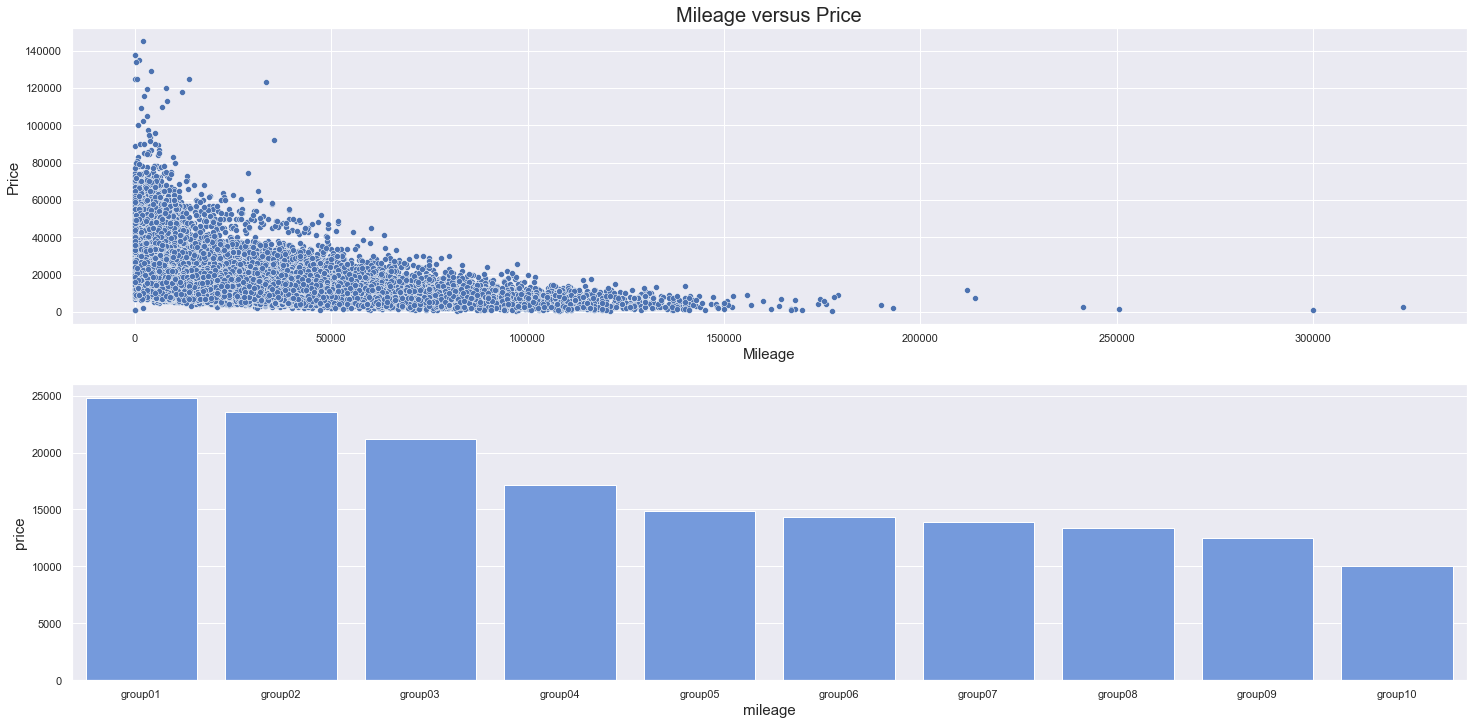

In [39]:
aux1 = df_aux[['mileage', 'price']].groupby('mileage').mean().reset_index()

plt.subplot(2, 1, 1)
plt.title('Mileage versus Price', fontdict = {'fontsize':20})
plt.xlabel('Mileage', fontsize=15)
plt.ylabel('Price', fontsize=15)
sns.scatterplot(x='mileage', y='price', data = df4)

plt.subplot(2, 1, 2)
plt.xlabel('Mileage', fontsize=15)
plt.ylabel('Price', fontsize=15)
sns.barplot(x='mileage', y='price', data=aux1, color='cornflowerblue')

### **H06** - Eletric cars are more expensive

*False* - Eletric cars are, on average, cheaper than Diesel and Hybric cars

<AxesSubplot:title={'center':'Avarege price for different fuel types'}, xlabel='fuel_type', ylabel='price'>

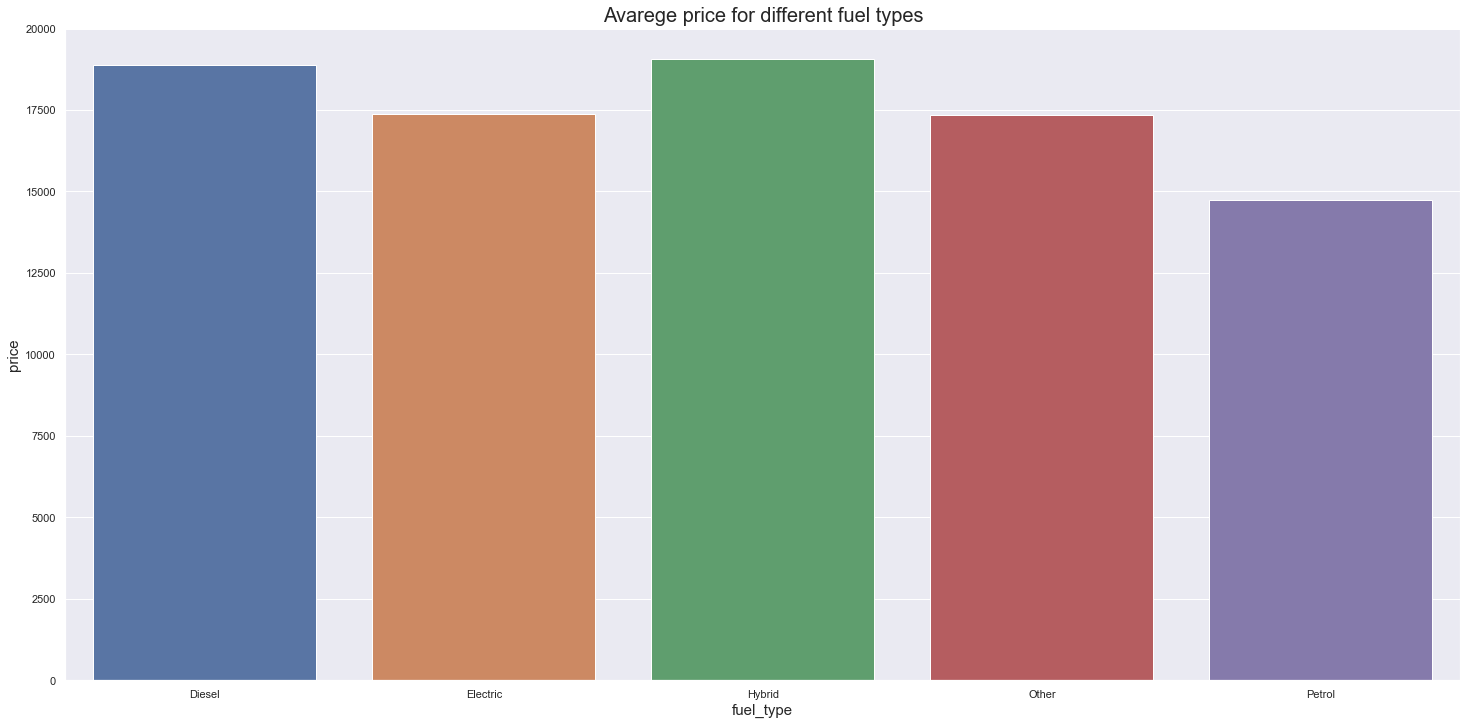

In [40]:
aux = df4[['fuel_type', 'price']].groupby('fuel_type').mean().reset_index()

plt.title('Avarege price for different fuel types', fontdict = {'fontsize':20})
plt.xlabel('Fuel Type', fontsize=15)
plt.ylabel('Price', fontsize=15)
sns.barplot(x='fuel_type', y='price', data=aux)

### **H07** - Cars with higher tax are more expensive

*False* - The most expensive cars has the same value of tax, 145

<AxesSubplot:title={'center':'Tax versus Price'}, xlabel='tax', ylabel='price'>

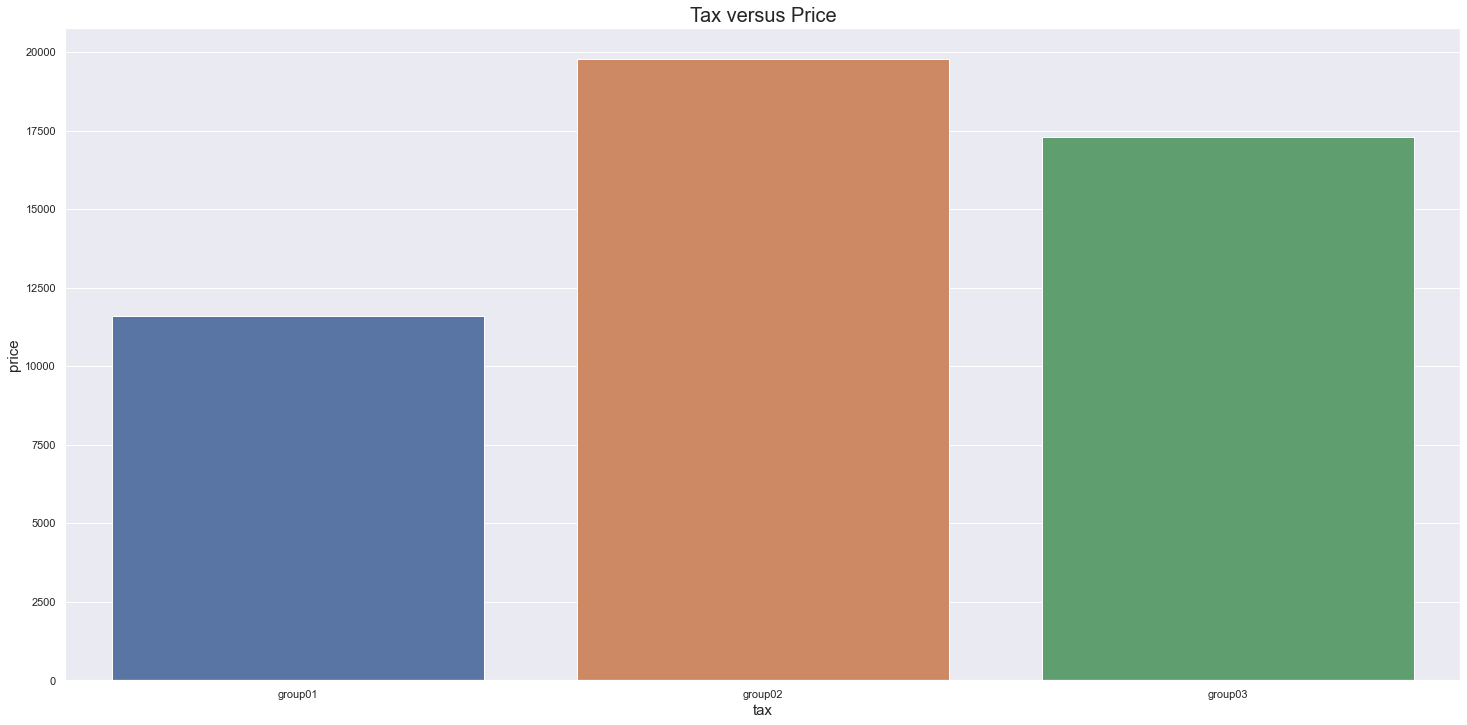

In [41]:
df_aux = df4.copy()
df_aux['tax'] = df_aux['tax'].apply(lambda x: 'group01' if (x < 145) 
                                         else 'group02' if (x == 145)
                                         else 'group03')

aux = df_aux[['tax', 'price']].groupby('tax').mean().reset_index()

plt.title('Tax versus Price', fontdict = {'fontsize':20})
plt.xlabel('Tax', fontsize=15)
plt.ylabel('Price', fontsize=15)
sns.barplot(x='tax', y='price', data=aux)

In [42]:
df_most_expensive['tax'].value_counts()

145.0    70
150.0    21
135.0     3
300.0     2
570.0     2
20.0      1
140.0     1
Name: tax, dtype: int64

### **H08** - Petrol or Diesel cars with higher mpg are more expensive

*False* - Petrol and Diesel cars with lower mpg are more expensive

In [43]:
df_aux = df4[(df4['fuel_type']=='Petrol') | (df4['fuel_type']=='Diesel')]

<AxesSubplot:xlabel='mpg'>

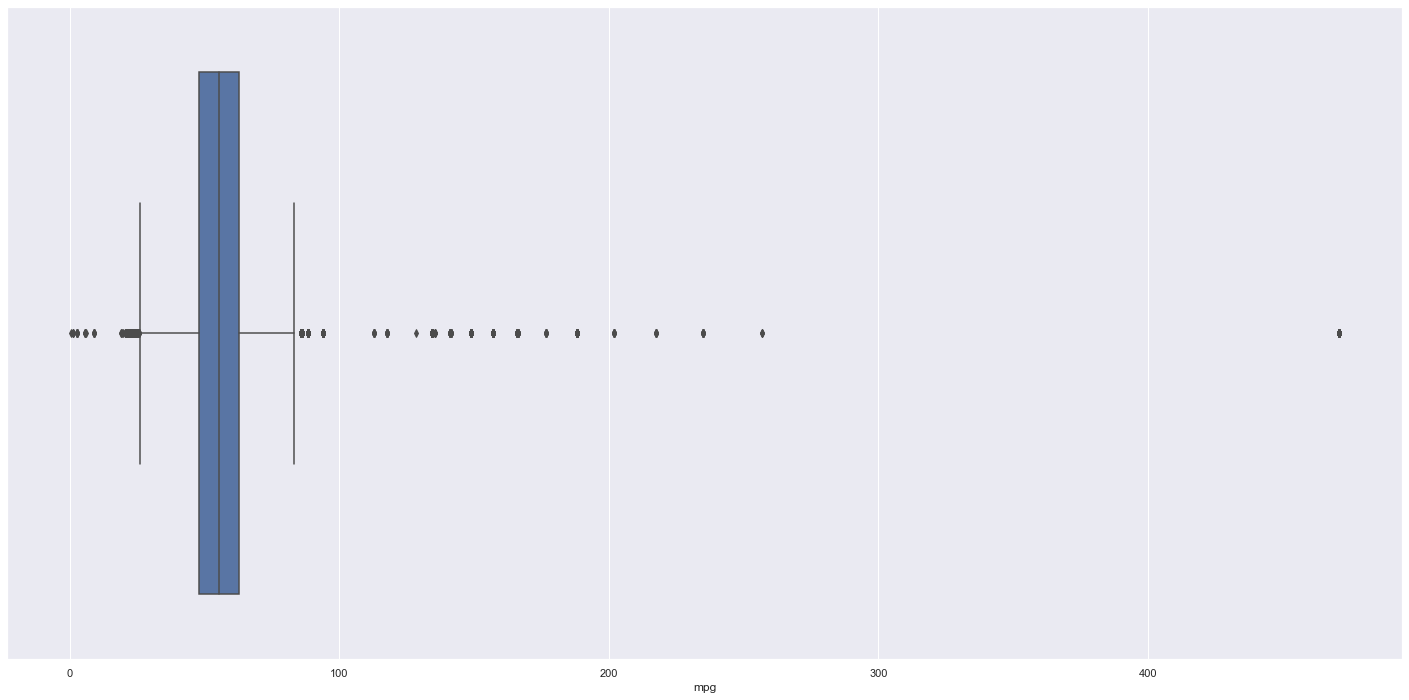

In [44]:
sns.boxplot(df4['mpg'])

In [45]:
list3 = []
for i in range(1, 11):
    aux = df_aux['mpg'].quantile(i*0.1)
    list3.append(aux)

df_aux['mpg'] = df_aux['mpg'].apply(lambda x: 'group01' if x < list3[0] 
                                        else 'group02'      if (x>list3[0])&(x<list3[1])
                                        else 'group03'    if (x>list3[1])&(x<list3[2])
                                        else 'group04'     if (x>list3[2])&(x<list3[3])
                                        else 'group05'     if (x>list3[3])&(x<list3[4])
                                        else 'group06'      if (x>list3[4])&(x<list3[5])
                                        else 'group07'    if (x>list3[5])&(x<list3[6])
                                        else 'group08'    if (x>list3[6])&(x<list3[7])
                                        else 'group09'     if (x>list3[7])&(x<list3[8])
                                        else 'group10')

<AxesSubplot:title={'center':'Price versus Mpg for Petrol or Diesel cars'}, xlabel='mpg', ylabel='price'>

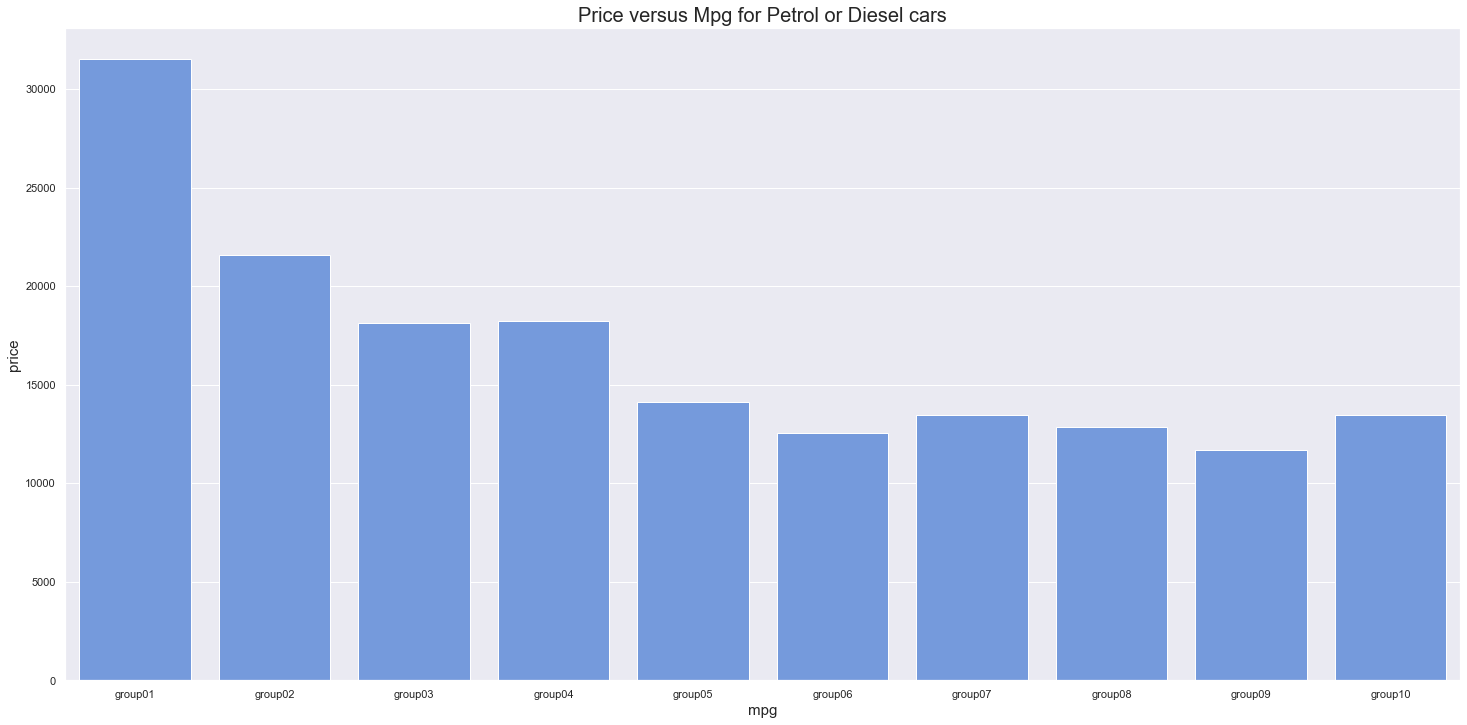

In [46]:
aux1 = df_aux[['mpg', 'price']].groupby('mpg').mean().reset_index()

plt.title('Price versus Mpg for Petrol or Diesel cars', fontdict = {'fontsize':20})
plt.xlabel('Mpg', fontsize=15)
plt.ylabel('Price', fontsize=15)
sns.barplot(x='mpg', y='price', data=aux1, color='cornflowerblue')

### **H09** - Cars with bigger engines are more expensive

*False* - However, there is a tendency for cars with larger engines to be more expensive.

<AxesSubplot:title={'center':'Average Price for different engine sizes'}, xlabel='engine_size', ylabel='price'>

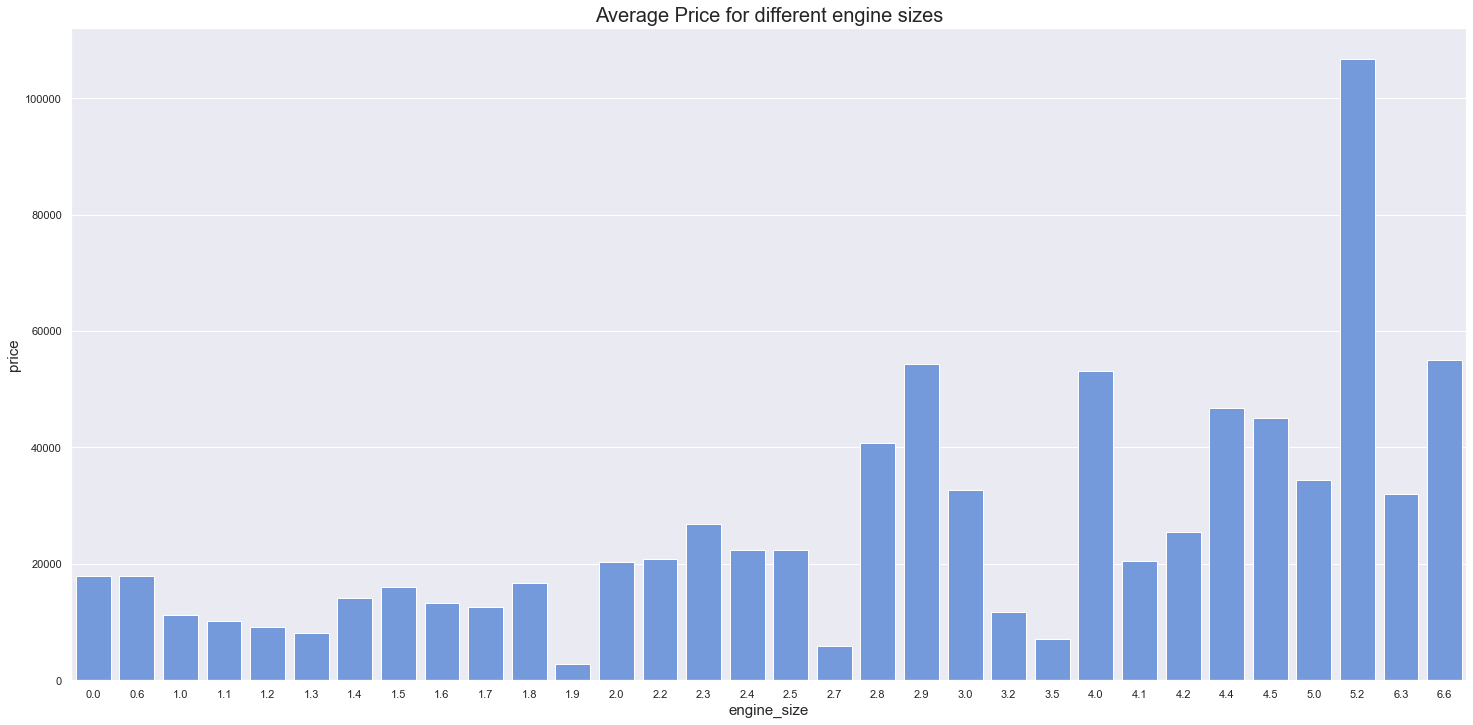

In [47]:
aux = df4[['engine_size', 'price']].groupby('engine_size').mean().reset_index()

plt.title('Average Price for different engine sizes', fontdict = {'fontsize':20})
plt.xlabel('Engine Size', fontsize=15)
plt.ylabel('Price', fontsize=15)
sns.barplot(x='engine_size', y='price', data=aux, color='cornflowerblue')

### **H10** - Diesel cars have higher tax

*False* - Petrol cars have higher tax on average

<AxesSubplot:title={'center':'Average tax for different fuel types'}, xlabel='fuel_type', ylabel='tax'>

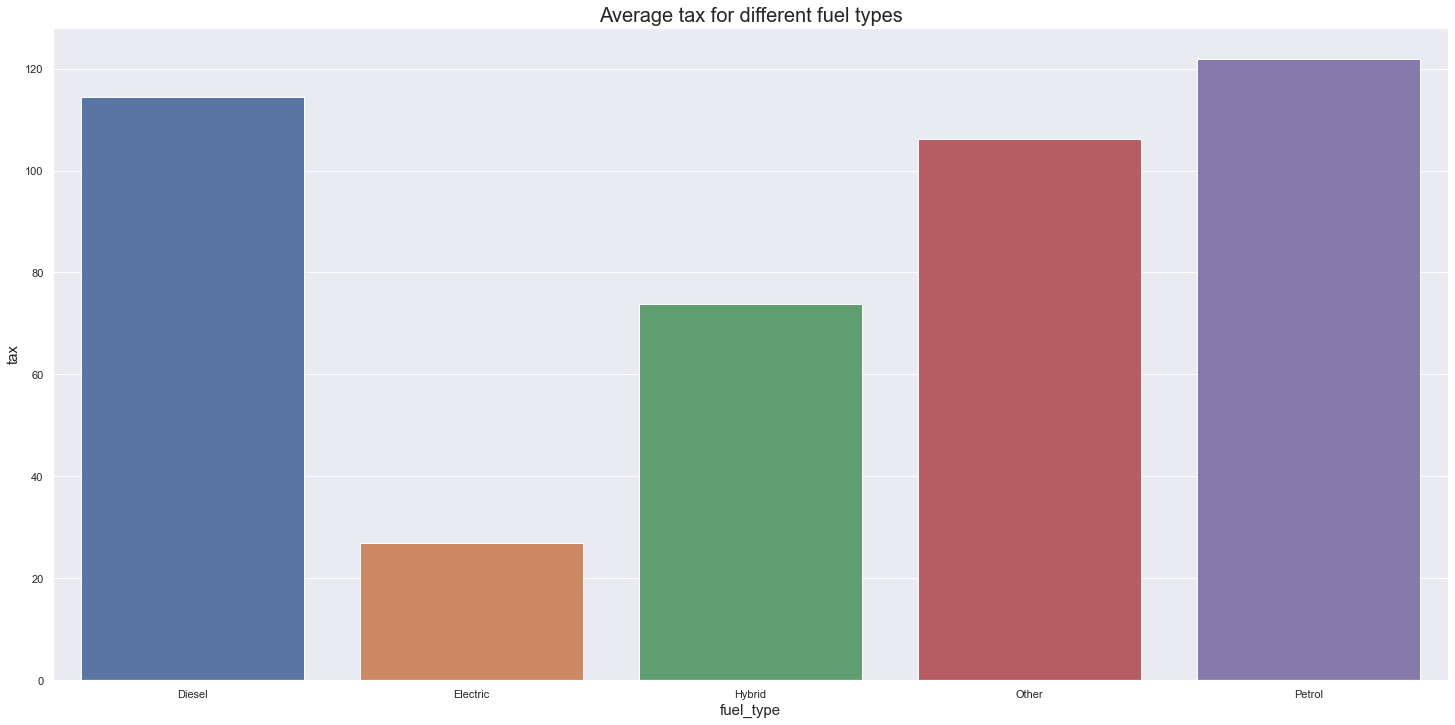

In [48]:
aux = df4[['fuel_type', 'tax']].groupby('fuel_type').mean().reset_index()

plt.title('Average tax for different fuel types', fontdict = {'fontsize':20})
plt.xlabel('Fuel Type', fontsize=15)
plt.ylabel('Tax', fontsize=15)
sns.barplot(x='fuel_type', y='tax', data=aux)

## 4.3 Multivariated Analysis

In [49]:
df4.head()

,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,make,price
0,A1,3,Manual,15735,Petrol,150.0,55.4,1.4,audi,12500
1,A6,4,Automatic,36203,Diesel,20.0,64.2,2.0,audi,16500
2,A1,4,Manual,29946,Petrol,30.0,55.4,1.4,audi,11000
3,A4,3,Automatic,25952,Diesel,145.0,67.3,2.0,audi,16800
4,A3,1,Manual,1998,Petrol,145.0,49.6,1.0,audi,17300


<AxesSubplot:>

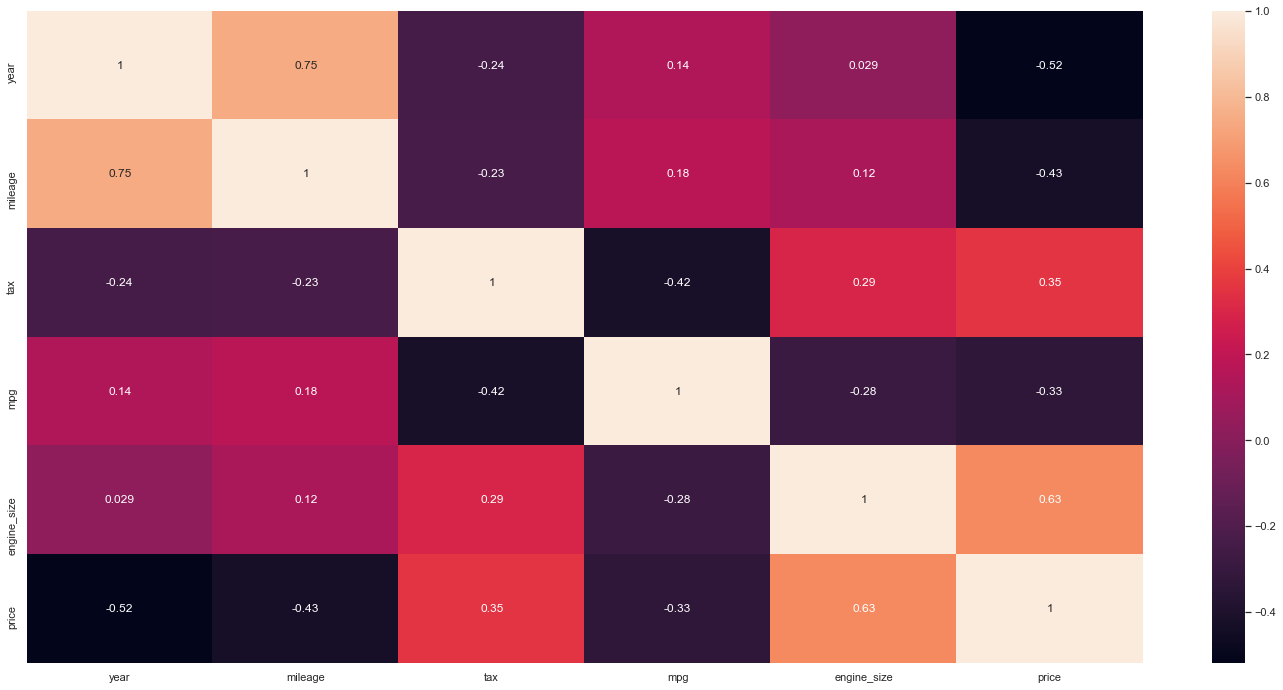

In [50]:
df4_num = df4[['year', 'mileage', 'tax', 'mpg', 'engine_size', 'price']]
correlation = df4_num.corr(method='pearson')
sns.heatmap(correlation, annot=True)

# 5.0 Data Preparation

In [51]:
df5 = df4.copy()

In [52]:
df5.head()

,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,make,price
0,A1,3,Manual,15735,Petrol,150.0,55.4,1.4,audi,12500
1,A6,4,Automatic,36203,Diesel,20.0,64.2,2.0,audi,16500
2,A1,4,Manual,29946,Petrol,30.0,55.4,1.4,audi,11000
3,A4,3,Automatic,25952,Diesel,145.0,67.3,2.0,audi,16800
4,A3,1,Manual,1998,Petrol,145.0,49.6,1.0,audi,17300


## 5.1 Frequency Encoding

In [53]:
#model
fe_model = df5['model'].value_counts(normalize=True)
df5.loc[:, 'model'] = df5['model'].map(fe_model)

#engine_size
fe_es = df5['engine_size'].value_counts(normalize=True)
df5.loc[:, 'engine_size'] = df5['engine_size'].map(fe_es)

#make
fe_make = df5['make'].value_counts(normalize=True)
df5.loc[:, 'make'] = df5['make'].map(fe_make)

## 5.2 One Hot Encoding

In [54]:
df5 = pd.get_dummies(df5, prefix=['transmission'], columns=['transmission'])

## 5.3 Label Encoding

In [55]:
le = LabelEncoder()
df5['fuel_type'] = le.fit_transform(df5['fuel_type'])

## 5.4 Robust Scaler

In [56]:
rs = RobustScaler()

#mileage
df5['mileage'] = rs.fit_transform(df5[['mileage']].values)

#tax
df5['tax'] = rs.fit_transform(df5[['tax']].values)

#mpg
df5['mpg'] = rs.fit_transform(df5[['mpg']].values)

# 6.0 Feature Selection

In [57]:
df6 = df5.copy()

## 6.1 Split into train and test

In [58]:
X = df6.drop(['price'], axis=1).copy()
y = df6[['price']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## 6.2 Feature Importance

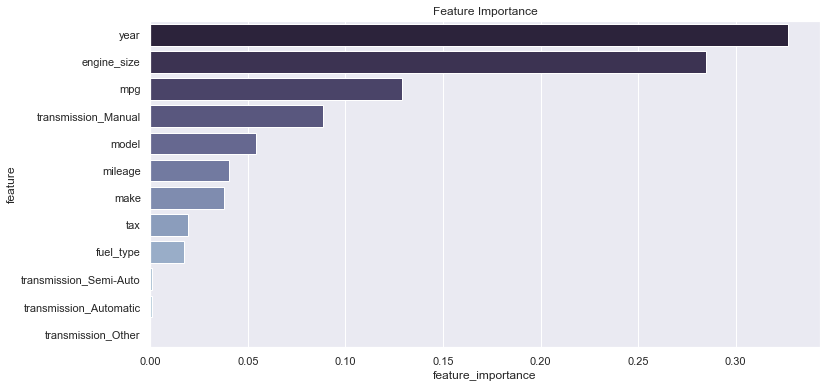

In [59]:
# train random forest classifier
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

#feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)

# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', palette="ch:s=.25,rot=-.25_r")\
    .set_title('Feature Importance');

## 6.3 Boruta as Feature Selector

In [60]:
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

boruta = BorutaPy( rf, n_estimators='auto', verbose = 2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	3


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	3


In [61]:
cols_selected = boruta.support_.tolist()

##best features
cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()

In [62]:
cols_selected_boruta

['model',
 'year',
 'mileage',
 'fuel_type',
 'tax',
 'mpg',
 'engine_size',
 'make',
 'transmission_Manual']

# 7.0 Machine Learning

## 7.1 Linear Regression

In [63]:
lr = LinearRegression()

lr.fit(X_train, y_train)

yhat_lr = lr.predict(X_test)

lr_results = ml_error('Linear Regression', y_test, yhat_lr)
lr_results

,Model name,ME,MAE,MSE,RMSE,MAPE
0,Linear Regression,107117.411409,3854.447451,3.581861e+07,5984.865053,0.271993


### 7.1.2 Linear Regression Cross Validation

In [64]:
lr_results_cv = cross_validation(df6, 5, 'Linear Regression', lr, verbose=False)
lr_results_cv

          Model name             ME          MAE           MSE       RMSE      MAPE
0  Linear Regression  107277.192152  3862.632618  3.604630e+07  6003.8571  0.268941
          Model name            ME          MAE           MSE         RMSE      MAPE
0  Linear Regression  106641.11469  3852.207375  3.493830e+07  5910.863288  0.272835
          Model name             ME          MAE           MSE         RMSE      MAPE
0  Linear Regression  107372.945439  3870.995278  3.514998e+07  5928.741853  0.276973
          Model name            ME          MAE           MSE         RMSE      MAPE
0  Linear Regression  113882.48079  3826.718433  3.419082e+07  5847.291983  0.274376
          Model name             ME          MAE           MSE         RMSE      MAPE
0  Linear Regression  108110.682874  3893.694119  3.706909e+07  6088.439062  0.271501


,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,Linear Regression,108656.88 +/- 2654.08,3861.25 +/- 22.02,3861.25+/- 990981.36,5955.84 +/- 82.98,0.27 +/- 0.0


## 7.2 Lasso

In [65]:
lml = Lasso(alpha=0.1)

lml.fit(X_train, y_train)

yhat_lml = lml.predict(X_test)

lml_results = ml_error('Lasso', y_test, yhat_lml)
lml_results

,Model name,ME,MAE,MSE,RMSE,MAPE
0,Lasso,107125.813832,3853.9541,3.582006e+07,5984.986432,0.271921


### 7.2.1 Lasso Cross Validation

In [66]:
lml_results_cv = cross_validation(df6, 5, 'Lasso', lml, verbose=False)
lml_results_cv

  Model name             ME         MAE           MSE         RMSE      MAPE
0      Lasso  107285.325051  3862.09647  3.604612e+07  6003.842095  0.268868
  Model name             ME          MAE           MSE         RMSE      MAPE
0      Lasso  106641.338436  3851.600431  3.493716e+07  5910.766208  0.272758
  Model name            ME          MAE           MSE         RMSE      MAPE
0      Lasso  107381.71353  3870.381411  3.514922e+07  5928.677747  0.276888
  Model name             ME          MAE           MSE         RMSE      MAPE
0      Lasso  113890.934177  3826.017242  3.419097e+07  5847.304473  0.274289
  Model name             ME          MAE           MSE        RMSE      MAPE
0      Lasso  108118.844033  3893.209694  3.707038e+07  6088.54486  0.271432


,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,Lasso,108663.63 +/- 2655.34,3860.66 +/- 22.08,3860.66+/- 991512.1,5955.83 +/- 83.02,0.27 +/- 0.0


## 7.3 Bayesian Regression

In [67]:
br = BayesianRidge()

br.fit(X_train, y_train.values.ravel())

yhat_br = br.predict(X_test)

br_results = ml_error('Bayesian Ridge', y_test, yhat_br)
br_results

,Model name,ME,MAE,MSE,RMSE,MAPE
0,Bayesian Ridge,107124.136758,3854.048037,3.582008e+07,5984.987721,0.271925


### 7.3.1 Bayesian Regression Cross Validation

In [68]:
br_results_cv = cross_validation(df6, 5, 'Bayesian Regression', br, verbose=False)
br_results_cv


            Model name             ME          MAE           MSE         RMSE     MAPE
0  Bayesian Regression  107284.439566  3862.122955  3.604619e+07  6003.847957  0.26886
            Model name             ME          MAE           MSE         RMSE      MAPE
0  Bayesian Regression  106642.238912  3851.703949  3.493699e+07  5910.752147  0.272757
            Model name             ME         MAE           MSE        RMSE      MAPE
0  Bayesian Regression  107380.409363  3870.43949  3.514929e+07  5928.68374  0.276886
            Model name             ME          MAE           MSE         RMSE      MAPE
0  Bayesian Regression  113889.755255  3826.222893  3.419226e+07  5847.415136  0.274296
            Model name             ME          MAE           MSE         RMSE      MAPE
0  Bayesian Regression  108117.868827  3893.226814  3.707035e+07  6088.542874  0.271426


,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,Bayesian Regression,108662.94 +/- 2655.0,3860.74 +/- 22.02,3860.74+/- 991189.74,5955.85 +/- 83.0,0.27 +/- 0.0


## 7.4 Random Forest Regressor

In [69]:
rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train.values.ravel())

yhat_rf = rf.predict(X_test)

rf_results = ml_error('Random Forest', y_test, yhat_rf)
rf_results

,Model name,ME,MAE,MSE,RMSE,MAPE
0,Random Forest,83410.81,1128.862322,3.996677e+06,1999.169131,0.071361


### 7.4.1 Random Forest Regressor Cross Validation

In [70]:
rf_results_cv = cross_validation(df6, 5, 'Random Forest', rf, verbose=False)
rf_results_cv

      Model name        ME          MAE           MSE         RMSE     MAPE
0  Random Forest  30083.38  1131.872231  3.279930e+06  1811.057573  0.07338
      Model name         ME          MAE           MSE         RMSE      MAPE
0  Random Forest  110487.63  1140.499038  4.233028e+06  2057.432381  0.073429
      Model name       ME          MAE           MSE         RMSE      MAPE
0  Random Forest  83275.7  1122.037544  3.913009e+06  1978.132703  0.071969
      Model name        ME         MAE           MSE        RMSE      MAPE
0  Random Forest  34478.82  1100.33632  2.946358e+06  1716.49598  0.071314
      Model name       ME          MAE           MSE         RMSE      MAPE
0  Random Forest  27377.4  1137.081884  3.121720e+06  1766.838859  0.073277


,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,Random Forest,57140.59 +/- 33646.53,1126.37 +/- 14.43,1126.37+/- 491110.06,1865.99 +/- 129.94,0.07 +/- 0.0


## 7.5 Ada Boost Regressor

In [71]:
ada = AdaBoostRegressor(random_state=42)

ada.fit(X_train, y_train.values.ravel())

yhat_ada = ada.predict(X_test)

ada_results = ml_error('Ada Boost', y_test, yhat_ada)
ada_results

,Model name,ME,MAE,MSE,RMSE,MAPE
0,Ada Boost,75197.829741,5092.732949,3.799020e+07,6163.61946,0.475538


### 7.5.1 Ada Boost Regressor

In [72]:
ada_results_cv = cross_validation(df6, 5, 'Ada Boost', ada, verbose=False)
ada_results_cv

  Model name            ME          MAE           MSE         RMSE      MAPE
0  Ada Boost  60476.616469  4515.254431  3.601198e+07  6000.998468  0.362014
  Model name             ME          MAE           MSE         RMSE      MAPE
0  Ada Boost  101469.327019  5863.897389  5.225178e+07  7228.539132  0.485015
  Model name            ME          MAE           MSE         RMSE      MAPE
0  Ada Boost  74826.666029  4384.062489  3.255447e+07  5705.652514  0.370877
  Model name           ME          MAE           MSE         RMSE      MAPE
0  Ada Boost  47227.72327  4619.876249  3.785647e+07  6152.761542  0.380539
  Model name           ME          MAE           MSE         RMSE      MAPE
0  Ada Boost  54473.14937  4329.863874  3.286278e+07  5732.606451  0.359027


,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,Ada Boost,67694.7 +/- 19169.76,4742.59 +/- 569.73,4742.59+/- 7247869.63,6164.11 +/- 557.87,0.39 +/- 0.05


## 7.6 Bagging Regressor

In [73]:
bag = BaggingRegressor(random_state=42)

bag.fit(X_train, y_train.values.ravel())

yhat_bag = bag.predict(X_test)

bag_results = ml_error('Bagging Regressor', y_test, yhat_bag)
bag_results

,Model name,ME,MAE,MSE,RMSE,MAPE
0,Bagging Regressor,83382.6,1170.169309,4.218608e+06,2053.925045,0.074019


### 7.6.1 Bagging Regressor Cross Validation

In [74]:
bag_results_cv = cross_validation(df6, 5, 'Bagging Regression', bag, verbose=False)
bag_results_cv

           Model name       ME          MAE           MSE         RMSE      MAPE
0  Bagging Regression  45542.1  1194.691041  3.940773e+06  1985.137927  0.077226
           Model name        ME          MAE           MSE         RMSE      MAPE
0  Bagging Regression  110770.6  1195.955559  4.582392e+06  2140.652328  0.076953
           Model name       ME          MAE           MSE         RMSE      MAPE
0  Bagging Regression  83421.1  1166.879469  4.321231e+06  2078.757044  0.074855
           Model name       ME          MAE           MSE         RMSE      MAPE
0  Bagging Regression  34388.5  1162.040255  3.380418e+06  1838.591182  0.075196
           Model name       ME          MAE           MSE         RMSE      MAPE
0  Bagging Regression  27621.2  1190.018741  3.469242e+06  1862.590046  0.076287


,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,Bagging Regression,60348.7 +/- 31745.74,1181.92 +/- 14.47,1181.92+/- 467492.12,1981.15 +/- 117.78,0.08 +/- 0.0


## 7.7 Extra Trees Regressor

In [75]:
et = ExtraTreesRegressor(random_state=42)

et.fit(X_train, y_train.values.ravel())

yhat_et = et.predict(X_test)

et_results = ml_error('Extra Trees Regressor', y_test, yhat_et)
et_results

,Model name,ME,MAE,MSE,RMSE,MAPE
0,Extra Trees Regressor,83366.03,1170.599119,4.290443e+06,2071.338492,0.074111


### 7.7.1 Extra Trees Regressor Cross Validation

In [76]:
et_results_cv = cross_validation(df6, 5, 'Extra Trees Regressor', et, verbose=False)
et_results_cv

              Model name        ME          MAE           MSE         RMSE     MAPE
0  Extra Trees Regressor  65323.49  1163.134039  3.800342e+06  1949.446567  0.07517
              Model name         ME          MAE           MSE         RMSE     MAPE
0  Extra Trees Regressor  111313.19  1132.314251  4.309837e+06  2076.014714  0.07347
              Model name       ME          MAE           MSE        RMSE      MAPE
0  Extra Trees Regressor  83408.0  1108.718284  3.814900e+06  1953.17684  0.071145
              Model name        ME          MAE           MSE         RMSE      MAPE
0  Extra Trees Regressor  31537.67  1100.079907  2.997252e+06  1731.257416  0.070877
              Model name        ME          MAE           MSE         RMSE      MAPE
0  Extra Trees Regressor  28009.78  1163.260415  3.278312e+06  1810.610911  0.075158


,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,Extra Trees Regressor,63918.43 +/- 31515.16,1133.5 +/- 26.44,1133.5+/- 458022.73,1904.1 +/- 120.53,0.07 +/- 0.0


## 7.8 Gradient Boosting Regressor

In [77]:
gb = GradientBoostingRegressor(random_state=42)

gb.fit(X_train, y_train.values.ravel())

yhat_gb = gb.predict(X_test)

gb_results = ml_error('Gradient Boosting Regressor', y_test, yhat_gb)
gb_results

,Model name,ME,MAE,MSE,RMSE,MAPE
0,Gradient Boosting Regressor,79146.461247,1873.866295,8.353553e+06,2890.251308,0.122751


### 7.8.1 Gradient Boosting Regressor Cross Validation

In [78]:
gb_results_cv = cross_validation(df6, 5, 'Gradient Boosting Regression', gb, verbose=False)
gb_results_cv

                     Model name            ME          MAE           MSE         RMSE      MAPE
0  Gradient Boosting Regression  65926.948108  1875.326967  7.665031e+06  2768.579178  0.123043
                     Model name             ME          MAE           MSE         RMSE      MAPE
0  Gradient Boosting Regression  107771.123312  1898.998919  8.650593e+06  2941.188997  0.127323
                     Model name            ME          MAE           MSE         RMSE      MAPE
0  Gradient Boosting Regression  79211.583239  1915.027432  8.298141e+06  2880.649375  0.127028
                     Model name           ME          MAE           MSE        RMSE      MAPE
0  Gradient Boosting Regression  36220.41653  1876.571351  7.387355e+06  2717.96886  0.124538
                     Model name         ME          MAE           MSE         RMSE      MAPE
0  Gradient Boosting Regression  31946.356  1895.996107  7.530118e+06  2744.106065  0.126075


,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,Gradient Boosting Regression,64215.29 +/- 28106.68,1892.38 +/- 14.9,1892.38+/- 485085.31,2810.5 +/- 85.71,0.13 +/- 0.0


## 7.9 XG Boost

In [79]:
xgb = XGBRegressor(random_state=42)

xgb.fit(X_train, y_train.values.ravel())

# Prediction
yhat_xgb = xgb.predict(X_test)

#Performance
xgb_results = ml_error( 'XGBoost Regressor', y_test, yhat_xgb)
xgb_results

,Model name,ME,MAE,MSE,RMSE,MAPE
0,XGBoost Regressor,84632.07373,1201.068476,4.055938e+06,2013.936035,0.076342


### 7.9.1 XGBoost Cross Validation

In [80]:
xgb_results_cv = cross_validation(df6, 5, 'XGBoost', xgb, verbose=False)
xgb_results_cv

  Model name            ME          MAE           MSE         RMSE      MAPE
0    XGBoost  36215.867188  1177.106433  3.163875e+06  1778.728457  0.075819
  Model name             ME          MAE           MSE         RMSE      MAPE
0    XGBoost  110460.047852  1215.072333  4.588810e+06  2142.150751  0.081525
  Model name            ME         MAE           MSE         RMSE      MAPE
0    XGBoost  84123.699219  1201.47928  4.009199e+06  2002.298327  0.077102
  Model name            ME         MAE           MSE         RMSE      MAPE
0    XGBoost  33200.210938  1184.06121  3.224695e+06  1795.743696  0.076431
  Model name           ME          MAE           MSE         RMSE      MAPE
0    XGBoost  28274.09375  1187.942949  3.199233e+06  1788.639876  0.077334


,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,XGBoost,58454.78 +/- 32883.67,1193.13 +/- 13.54,1193.13+/- 570956.45,1901.51 +/- 146.33,0.08 +/- 0.0


## 7.10 Performance with Cross Validation

In [81]:
performance = pd.concat([lr_results_cv, lml_results_cv, br_results_cv, rf_results_cv, ada_results_cv,
                         bag_results_cv, et_results_cv, gb_results_cv, xgb_results_cv], ignore_index=True)

performance

,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,Linear Regression,108656.88 +/- 2654.08,3861.25 +/- 22.02,3861.25+/- 990981.36,5955.84 +/- 82.98,0.27 +/- 0.0
1,Lasso,108663.63 +/- 2655.34,3860.66 +/- 22.08,3860.66+/- 991512.1,5955.83 +/- 83.02,0.27 +/- 0.0
2,Bayesian Regression,108662.94 +/- 2655.0,3860.74 +/- 22.02,3860.74+/- 991189.74,5955.85 +/- 83.0,0.27 +/- 0.0
3,Random Forest,57140.59 +/- 33646.53,1126.37 +/- 14.43,1126.37+/- 491110.06,1865.99 +/- 129.94,0.07 +/- 0.0
4,Ada Boost,67694.7 +/- 19169.76,4742.59 +/- 569.73,4742.59+/- 7247869.63,6164.11 +/- 557.87,0.39 +/- 0.05
5,Bagging Regression,60348.7 +/- 31745.74,1181.92 +/- 14.47,1181.92+/- 467492.12,1981.15 +/- 117.78,0.08 +/- 0.0
6,Extra Trees Regressor,63918.43 +/- 31515.16,1133.5 +/- 26.44,1133.5+/- 458022.73,1904.1 +/- 120.53,0.07 +/- 0.0
7,Gradient Boosting Regression,64215.29 +/- 28106.68,1892.38 +/- 14.9,1892.38+/- 485085.31,2810.5 +/- 85.71,0.13 +/- 0.0
8,XGBoost,58454.78 +/- 32883.67,1193.13 +/- 13.54,1193.13+/- 570956.45,1901.51 +/- 146.33,0.08 +/- 0.0


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Forest

In [82]:
param_rf = {'n_estimators': (100, 200, 500),
            'criterion': ('poisson', 'mse'),
            'max_features': ( 6, 8, 10, 'auto')}

par = sorted(param_rf)
combinations = it.product(*(param_rf[Name] for Name in par))
list1 = list(combinations)


for i in range (len(list1)):
    params= {par[0]: list1[i][0], par[1]: list1[i][1], par[2]: list1[i][2]}
    
    model_rf = RandomForestRegressor(n_estimators = params['n_estimators'],
                                     criterion  = params['criterion'],
                                     max_features = params['max_features'],
                                     random_state = 42,
                                     n_jobs = -1)

    model_rf.fit(X_train, y_train.values.ravel())

    yhat_rf = model_rf.predict(X_test)
    
    results = ml_error( 'Random Forest', y_test, yhat_rf)

    if i==0:
        result_hft = results
    else:
        result_hft = result_hft.append(results, ignore_index=True)
        
result = pd.DataFrame({'Model Name': 'Random Forest',
                    'ME': np.round(np.mean(result_hft['ME']), 2).astype(str) + ' +/- ' + np.round(np.std(result_hft['ME']), 2).astype(str),
                    'MAE': np.round(np.mean(result_hft['MAE']), 2).astype(str) + ' +/- ' + np.round(np.std(result_hft['MAE']), 2).astype(str),
                    'MSE': np.round(np.mean(result_hft['MSE']), 2).astype(str) + ' +/- ' + np.round(np.std(result_hft['MSE']), 2).astype(str),
                    'RMSE': np.round(np.mean(result_hft['RMSE']), 2).astype(str) + ' +/- ' + np.round(np.std(result_hft['RMSE']), 2).astype(str),
                    'MAPE': np.round(np.mean(result_hft['MAPE']), 2).astype(str) + ' +/- ' + np.round(np.std(result_hft['MAPE']), 2).astype(str)}, index=[0])
result_hft

,Model name,ME,MAE,MSE,RMSE,MAPE
0,Random Forest,76729.610,1394.535376,6.294007e+06,2508.785954,0.100799
1,Random Forest,76991.675,1392.232635,6.252720e+06,2500.544030,0.100662
2,Random Forest,77701.438,1390.097881,6.249614e+06,2499.922758,0.100713
3,Random Forest,76930.720,1513.316445,7.185203e+06,2680.522893,0.110154
4,Random Forest,77226.945,1509.485577,7.216907e+06,2686.430113,0.109913
5,Random Forest,77205.078,1504.792338,7.162324e+06,2676.251833,0.109861
6,Random Forest,76530.890,1649.767517,8.378517e+06,2894.566829,0.119836
7,Random Forest,76802.035,1645.107593,8.328096e+06,2885.844092,0.119616
8,Random Forest,76792.896,1642.481343,8.283406e+06,2878.090658,0.119424
9,Random Forest,76618.390,1799.113928,9.678270e+06,3110.991807,0.130246


In [83]:
result

,Model Name,ME,MAE,MSE,RMSE,MAPE
0,Random Forest,80115.45 +/- 3206.98,1350.7 +/- 257.27,5859449.2 +/- 2183211.13,2379.75 +/- 443.0,0.09 +/- 0.02


## 8.2 Extra Trees

In [84]:
param_et = {'n_estimators': (100, 200, 500),
            'max_features': ( 6, 8, 10, 'auto')}

par = sorted(param_et)
combinations = it.product(*(param_et[Name] for Name in par))
list1 = list(combinations)


for i in range (len(list1)):
    params= {par[0]: list1[i][0], par[1]: list1[i][1]}
    
    model_et = ExtraTreesRegressor(n_estimators = params['n_estimators'],
                                   criterion  = 'mse',
                                   max_features = params['max_features'],
                                   random_state = 42,
                                   n_jobs = -1)

    model_et.fit(X_train, y_train.values.ravel())

    yhat_et = model_et.predict(X_test)
    
    results = ml_error( 'Extra Trees', y_test, yhat_et)

    if i==0:
        result_hft = results
    else:
        result_hft = result_hft.append(results, ignore_index=True)
        
result = pd.DataFrame({'Model Name': 'Extra Trees',
                    'ME': np.round(np.mean(result_hft['ME']), 2).astype(str) + ' +/- ' + np.round(np.std(result_hft['ME']), 2).astype(str),
                    'MAE': np.round(np.mean(result_hft['MAE']), 2).astype(str) + ' +/- ' + np.round(np.std(result_hft['MAE']), 2).astype(str),
                    'MSE': np.round(np.mean(result_hft['MSE']), 2).astype(str) + ' +/- ' + np.round(np.std(result_hft['MSE']), 2).astype(str),
                    'RMSE': np.round(np.mean(result_hft['RMSE']), 2).astype(str) + ' +/- ' + np.round(np.std(result_hft['RMSE']), 2).astype(str),
                    'MAPE': np.round(np.mean(result_hft['MAPE']), 2).astype(str) + ' +/- ' + np.round(np.std(result_hft['MAPE']), 2).astype(str)}, index=[0])
result_hft

,Model name,ME,MAE,MSE,RMSE,MAPE
0,Extra Trees,82999.460,1174.413041,4.345229e+06,2084.521171,0.074329
1,Extra Trees,83027.810,1171.961851,4.305409e+06,2074.948051,0.074178
2,Extra Trees,82911.750,1168.993181,4.282270e+06,2069.364713,0.073986
3,Extra Trees,83114.650,1168.047086,4.222030e+06,2054.757814,0.073964
4,Extra Trees,83139.165,1168.344300,4.250470e+06,2061.666874,0.073999
5,Extra Trees,83070.104,1166.760038,4.252474e+06,2062.152703,0.073867
6,Extra Trees,83378.640,1166.416961,4.244886e+06,2060.312040,0.073646
7,Extra Trees,83270.070,1165.353912,4.269839e+06,2066.358849,0.073687
8,Extra Trees,83303.416,1165.305626,4.264553e+06,2065.079415,0.073742
9,Extra Trees,83366.030,1170.599119,4.290443e+06,2071.338492,0.074111


In [85]:
result

,Model Name,ME,MAE,MSE,RMSE,MAPE
0,Extra Trees,83211.24 +/- 184.39,1168.21 +/- 2.74,4267436.96 +/- 32693.29,2065.76 +/- 7.9,0.07 +/- 0.0


## 8.3 XGBoost

In [86]:
param_xgb = {'n_estimators': (100, 200, 500)}
#             'subsample': [0.1, 0.5, 0.7],
#             'colsample_bytree': [0.3, 0.7, 0.9]}
#            'boosters': ( 'gbtree', 'gblinear', 'dart')}
#            'eval_method' : ('mean_absolute_error', 'mean_squared_error')}
#            'tree_metric' : ('exact', 'hist')

par = sorted(param_xgb)
combinations = it.product(*(param_xgb[Name] for Name in par))
list1 = list(combinations)


for i in range (len(list1)):
    params= {par[0]: list1[i][0]}
    
    model_xgb = XGBRegressor(n_estimators = params['n_estimators'],
                             random_state = 42,
                             n_jobs = -1,
                             eval_metric='mlogloss')

    model_xgb.fit(X_train, y_train.values.ravel())

    yhat_xgb = model_xgb.predict(X_test)

    results = cross_validation(df6, 5, 'XGBoost', model_xgb, verbose=False)
    
    display(results)

  Model name            ME          MAE           MSE         RMSE      MAPE
0    XGBoost  36215.867188  1177.106433  3.163875e+06  1778.728457  0.075819
  Model name             ME          MAE           MSE         RMSE      MAPE
0    XGBoost  110460.047852  1215.072333  4.588810e+06  2142.150751  0.081525
  Model name            ME         MAE           MSE         RMSE      MAPE
0    XGBoost  84123.699219  1201.47928  4.009199e+06  2002.298327  0.077102
  Model name            ME         MAE           MSE         RMSE      MAPE
0    XGBoost  33200.210938  1184.06121  3.224695e+06  1795.743696  0.076431
  Model name           ME          MAE           MSE         RMSE      MAPE
0    XGBoost  28274.09375  1187.942949  3.199233e+06  1788.639876  0.077334


,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,XGBoost,58454.78 +/- 32883.67,1193.13 +/- 13.54,1193.13+/- 570956.45,1901.51 +/- 146.33,0.08 +/- 0.0


  Model name            ME          MAE           MSE         RMSE      MAPE
0    XGBoost  37478.851562  1125.908723  2.981502e+06  1726.702755  0.072357
  Model name             ME          MAE           MSE         RMSE      MAPE
0    XGBoost  110059.466797  1162.143694  4.357214e+06  2087.394174  0.078093
  Model name            ME          MAE           MSE         RMSE     MAPE
0    XGBoost  84140.325195  1142.150384  3.767005e+06  1940.877395  0.07306
  Model name            ME          MAE           MSE         RMSE      MAPE
0    XGBoost  33358.707031  1121.399567  2.959065e+06  1720.193341  0.072266
  Model name            ME          MAE           MSE         RMSE      MAPE
0    XGBoost  28478.949219  1132.589883  2.993049e+06  1730.043171  0.073317


,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,XGBoost,58703.26 +/- 32529.48,1136.84 +/- 14.45,1136.84+/- 563108.48,1841.04 +/- 148.76,0.07 +/- 0.0


  Model name            ME          MAE           MSE         RMSE      MAPE
0    XGBoost  40155.445312  1105.930496  2.959437e+06  1720.301438  0.070841
  Model name             ME          MAE           MSE         RMSE     MAPE
0    XGBoost  109848.166992  1124.529435  4.220150e+06  2054.300371  0.07576
  Model name            ME        MAE           MSE         RMSE      MAPE
0    XGBoost  84249.103516  1112.6729  3.684796e+06  1919.582225  0.070843
  Model name            ME          MAE           MSE         RMSE      MAPE
0    XGBoost  33441.128906  1100.179361  2.934412e+06  1713.012502  0.070851
  Model name            ME          MAE           MSE         RMSE      MAPE
0    XGBoost  25951.457031  1107.183818  2.910082e+06  1705.896336  0.071426


,Model Name,ME CV,MAE CV,MSE CV,RMSE CV,MAPE CV
0,XGBoost,58729.06 +/- 32629.02,1110.1 +/- 8.24,1110.1+/- 526819.07,1822.62 +/- 140.84,0.07 +/- 0.0


## 8.4 Final Model

In [87]:
model = XGBRegressor(n_estimators = 200,
                     random_state = 42,
                     eval_metric='mlogloss',
                     n_jobs = -1)

model.fit(X_train, y_train.values.ravel())

yhat = model.predict(X_test)

# 9.0 Business Performance

In [88]:
df9 = X_test.copy()

In [89]:
df9['price'] = y_test

df9['prediction'] = yhat

df9['error'] = df9['price'] - df9['prediction']

df9['percentage_error'] = abs((100 * df9['error'] / df9['price']).round(2))

df9['return'] = ((df9['price'] - abs(df9['error']))*0.05).round(2)

In [90]:
df91 = df9.copy()

In [91]:
df9 = df9[df9['percentage_error'] <= 5]

In [92]:
df9.head()

,model,year,mileage,fuel_type,tax,mpg,engine_size,make,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,price,prediction,error,percentage_error,return
7979,0.019065,4,2.078268,0,-1.086957,1.020134,0.315842,0.147277,0,1,0,0,11990,11851.469727,138.530273,1.16,592.57
3026,0.019562,3,0.501574,0,0.000000,0.000000,0.315842,0.147277,0,0,0,1,19998,20029.945312,-31.945312,0.16,998.30
66160,0.010920,4,1.568891,0,-1.086957,0.906040,0.315842,0.086519,0,1,0,0,11490,11984.950195,-494.950195,4.31,549.75
5954,0.026631,1,-0.451865,4,0.000000,-1.402685,0.315842,0.147277,0,0,0,1,32490,32394.802734,95.197266,0.29,1619.74
27983,0.090509,6,0.573307,4,-1.000000,-0.073826,0.069262,0.248002,0,1,0,0,6720,6467.870117,252.129883,3.75,323.39


## 9.1 Main Insights

For different types of transmission, just whether the vehicle is manual or not was significant in determining the vehicle price.

There is a tendency for cars with larger engines and high mpg to be more expensive.

There is a common tax value on approximately 70%  of the most expensive cars.

The characteristics that proved to be most important in determining the vehicle price are year and mileage with a high correlation between them.

## 9.2 Easy Transactions

In [93]:
print('A total of {} easy transactions were made.'.format(len(df9)))

print('This corresponds to {:.2f}% of the possible transactions.'.format((len(df9)/len(df91)*100)))

A total of 6762 easy transactions were made.
This corresponds to 46.68% of the possible transactions.


## 9.3 Return on Easy Transactions

In [94]:
total_return = df9['return'].sum()

print('The proposed model would generate a return of $ {:.2f}'.format(total_return))

The proposed model would generate a return of $ 5640690.87


## 9.4 Improvement compared to previous model

### 9.4.1 Previous Model

In [95]:
X_pv = df4.drop(['price'], axis=1).copy()
y_pv = df4[['price']].copy()

X_train_pv, X_test_pv, y_train_pv, y_test_pv = train_test_split(X_pv, y_pv, test_size = 0.2, random_state = 42)

df_pv = X_train_pv.copy()

df_pv['price'] = y_train_pv

df_pv_selected = df_pv[['model', 'year', 'price']]

df_value = df_pv_selected[['model', 'year', 'price']].groupby(['model', 'year']).mean().reset_index()

df_test_pv = X_test_pv.copy()

df_test_pv['price'] = y_test_pv

df_test_pv = df_test_pv[['model', 'year', 'price']]

df_prediction_pv = pd.merge(df_test_pv, df_value,  how='left', left_on=['model','year'], right_on = ['model','year'])

df_prediction_pv.columns = ['model', 'year', 'price', 'prediction']

df_prediction_pv['error'] = df_prediction_pv['price'] - df_prediction_pv['prediction']

df_prediction_pv['percentage_error'] = abs((100 * df_prediction_pv['error'] / df_prediction_pv['price']).round(2))

df_prediction_pv['return'] = ((df_prediction_pv['price'] - abs(df_prediction_pv['error']))*0.05).round(2)

df_prediction_pv = df_prediction_pv.dropna()

df_prediction_pv.head()

,model,year,price,prediction,error,percentage_error,return
0,Aygo,3,8495,7669.571146,825.428854,9.72,383.48
1,A8,1,39990,43429.625000,-3439.625000,8.60,1827.52
2,A4,4,11990,15305.394422,-3315.394422,27.65,433.73
3,Octavia,1,16450,16513.169643,-63.169643,0.38,819.34
4,Q3,3,19998,19473.934498,524.065502,2.62,973.70


### 9.4.2 Improvement

In [96]:
aux = df_prediction_pv[df_prediction_pv['percentage_error'] <= 5]

In [97]:
print('The current model has a mean percentage error of {:.2f}'.format((df_prediction_pv['percentage_error'].mean())))
print('The proposed model has a mean percentage error of {:.2f}'.format((df91['percentage_error'].mean())))

The current model has a mean percentage error of 12.64
The proposed model has a mean percentage error of 7.16


In [98]:
print('The current model performs a total of {} easy transactions'.format(len(aux)))
print('Which corresponds to {:.2f}% of possible transactions'.format((len(aux)/len(df_prediction_pv))*100))
print('The current model generates a profit of $ {:.2f}'.format(aux['return'].sum()))


print('The proposed model increases the number of easy transactions by {}'.format(len(df9)-len(aux)))
print('The proposed model increases the profit to $ {:.2f}'.format(((df9['return'].sum())-(aux['return'].sum())) + (aux['return'].sum())))

The current model performs a total of 3955 easy transactions
Which corresponds to 27.39% of possible transactions
The current model generates a profit of $ 3280862.76
The proposed model increases the number of easy transactions by 2807
The proposed model increases the profit to $ 5640690.87


## 9.5 Best cars to buy

In [99]:
aux = df91[['price', 'prediction', 'error', 'percentage_error', 'return']].sort_values('error').head(10)

In [100]:
aux.head()

,price,prediction,error,percentage_error,return
701,12500,32285.625000,-19785.625000,158.28,-364.28
14883,21498,38139.621094,-16641.621094,77.41,242.82
7128,119450,134349.562500,-14899.562500,12.47,5227.52
7858,13500,27112.503906,-13612.503906,100.83,-5.63
7027,41500,51549.218750,-10049.218750,24.21,1572.54


In [101]:
df4.iloc[aux.index]

,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,make,price
701,Q7,4,Semi-Auto,26705,Diesel,200.0,47.9,3.0,audi,12500
14883,7 Series,6,Semi-Auto,24528,Petrol,300.0,32.8,4.4,BMW,21498
7128,R8,1,Automatic,3000,Petrol,145.0,21.4,5.2,audi,119450
7858,A5,5,Manual,33430,Diesel,30.0,60.1,2.0,audi,13500
7027,A6,2,Semi-Auto,17142,Petrol,145.0,29.4,4.0,audi,41500
6698,A6,1,Semi-Auto,2000,Diesel,145.0,39.2,3.0,audi,34000
28613,Mustang,0,Semi-Auto,3200,Petrol,145.0,24.8,5.0,Ford,40495
52842,Caravelle,1,Semi-Auto,1099,Diesel,145.0,32.8,2.0,vw,35495
15022,M2,1,Semi-Auto,19548,Petrol,145.0,29.1,3.0,BMW,37990
29706,Focus,3,Manual,13626,Petrol,145.0,36.7,2.3,Ford,25990


## 9.6 Worst cars to buy

In [102]:
aux = df91[['price', 'prediction', 'error', 'percentage_error', 'return']].sort_values('error').tail(10)

In [103]:
aux.tail()

,price,prediction,error,percentage_error,return
53169,57295,37854.906250,19440.093750,33.93,1892.75
13577,89990,54055.488281,35934.511719,39.93,2702.77
16030,99950,54263.082031,45686.917969,45.71,2713.15
66301,91874,23141.746094,68732.253906,74.81,1157.09
71822,92000,7144.673828,84855.326172,92.23,357.23


In [104]:
df4.iloc[aux.index]

,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,make,price
13090,5 Series,1,Semi-Auto,101,Petrol,145.0,50.4,2.0,BMW,42650
17534,4 Series,0,Semi-Auto,102,Diesel,145.0,65.7,2.0,BMW,42520
15444,M5,1,Semi-Auto,2269,Petrol,145.0,24.1,4.4,BMW,89900
4048,Q7,1,Automatic,6000,Diesel,145.0,33.2,3.0,audi,66990
11912,4 Series,0,Semi-Auto,101,Diesel,145.0,60.1,2.0,BMW,47550
53169,Touareg,2,Automatic,10000,Diesel,145.0,34.0,3.0,vw,57295
13577,M4,3,Semi-Auto,1336,Petrol,145.0,33.2,3.0,BMW,89990
16030,M4,4,Automatic,771,Petrol,300.0,33.2,3.0,BMW,99950
66301,Karoq,1,Automatic,3764,Petrol,145.0,40.9,1.5,skoda,91874
71822,I10,3,Automatic,35460,Petrol,150.0,47.9,1.2,Hyundai,92000


# 10.0 Deploy

In [38]:
#Saving trained Model 
pickle.dump(model, open('trained_model/price_prediction_model.pkl', 'wb'))

pickle.dump(le, open('preparation/le_fuel_type.pkl', 'wb'))
pickle.dump(rs, open('preparation/rs_mileage.pkl', 'wb'))
pickle.dump(rs, open('preparation/rs_tax.pkl', 'wb'))
pickle.dump(rs, open('preparation/rs_mpg.pkl', 'wb'))

## 10.1 Principal Class

In [97]:
import pickle
import numpy  as np
import pandas as pd

class Principal:
    def __init__(self):
        self.fuel_type = pickle.load(open('preparation/le_fuel_type.pkl', 'rb'))
        self.mileage = pickle.load(open('preparation/rs_mileage.pkl', 'rb'))
        self.tax = pickle.load(open('preparation/rs_tax.pkl', 'rb'))
        self.mpg = pickle.load(open('preparation/rs_mpg.pkl', 'rb'))

    def data_cleaning( self, df ):
        
        cols_new = ['model', 'year', 'transmission', 'mileage', 'fuel_type', 'tax', 'mpg', 'engine_size', 'make', 'price']
        df.columns = cols_new
    
        return df

    def data_preparation(self, df):

        #model
        fe_model = df['model'].value_counts(normalize=True)
        df.loc[:, 'model'] = df['model'].map(fe_model)
        
        #year
        df['year'] = (2020 - df['year'])
        
        #transmission
        df = pd.get_dummies(df, prefix=['transmission'], columns=['transmission'])

        #mileage
        df['mileage'] = self.mileage.transform(df[['mileage']].values)
        
        #fuel_type
        df['fuel_type'] = self.fuel_type.transform(df[['fuel_type']].values)
        
        #tax
        df['tax'] = self.tax.transform(df[['tax']].values)
        
        #mpg
        df['mpg'] = self.mpg.transform(df[['mpg']].values)
        
        #engine_size
        fe_es = df['engine_size'].value_counts(normalize=True)
        df.loc[:, 'engine_size'] = df['engine_size'].map(fe_es)

        #make
        fe_make = df['make'].value_counts(normalize=True)
        df.loc[:, 'make'] = df['make'].map(fe_make)
        
        return df
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict( test_data )
        
        # join prediction into original data
        original_data['prediction'] = pred
        return original_data.to_json( orient='records', date_format='iso')

## 10.2 API Handler

In [155]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from main.Principal import Principal
import xgboost

# loading model
model = pickle.load( open( 'trained_model/price_prediction_model.pkl', 'rb' ) )

# initialize API
app = Flask( __name__ )

@app.route( '/path/predict', methods=['POST'] )
def path_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        #instantiate 
        pipeline = Principal()
        
        # data cleaning
        df = pipeline.data_cleaning( test_raw )

        # data preparation
        df = pipeline.data_preparation(df)
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df )
        
        return df_response


    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '0.0.0.0', debug=True )

ModuleNotFoundError: No module named 'main'

## 10.3 API Test

In [105]:
df10 = pd.read_csv('C:/Users/Igor Justino/Project/Cars/test.csv')

#convert into json
data = json.dumps(df10.to_dict(orient='records'))


In [106]:
 # API Call

url = 'https://car-price-prediction-easyt.herokuapp.com/path/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url = url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [107]:
df_result = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [108]:
df_result.head()

,model,year,transmission,mileage,fuel_type,tax,mpg,engine_size,make,price,prediction
0,0.027128,3,Semi-Auto,11879,Petrol,145.0,67.0,1.0,toyota,8495,8243.898438
1,0.001657,1,Automatic,6392,Diesel,145.0,50.4,3.0,audi,39990,29279.968750
2,0.018223,4,Manual,70000,Diesel,20.0,70.6,2.0,audi,11990,9300.947266
3,0.022503,1,Semi-Auto,3815,Diesel,145.0,67.3,2.0,skoda,16450,16120.436523
4,0.019121,3,Semi-Auto,30194,Diesel,145.0,55.4,2.0,audi,19998,16178.522461
